In [19]:
import os
import json
import random
import pickle
import math
from pathlib import Path
from utils import Tokenizer, Embedding
from torch.nn.utils import clip_grad_norm
from dataset import Seq2SeqDataset
from tqdm import tqdm
from tqdm import tnrange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from argparse import ArgumentParser
from attention_model import Encoder, Attention, Seq2Seq, Decoder

In [20]:
parser = ArgumentParser()
parser.add_argument('--test_data_path')
parser.add_argument('--output_path')
args = parser.parse_args()

TEST_DATA_PATH = args.test_data_path
OUT_DATA_PATH = args.output_path

usage: ipykernel_launcher.py [-h] [--test_data_path TEST_DATA_PATH]
                             [--output_path OUTPUT_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/littleemma/.local/share/jupyter/runtime/kernel-0021bfc6-a686-44b4-a291-c55efaa1dbbb.json


SystemExit: 2

/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
TEST_DATA_PATH = '../datasets/seq2seq/valid.pkl'
with open(TEST_DATA_PATH, "rb") as f:
    test = pickle.load(f)
with open("../datasets/seq2seq/embedding.pkl", "rb") as f:
    embedding = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
en_size = len(embedding.vocab)
hidden_size = 300
lr = 0.001
encoder = Encoder(en_size, embedding, hidden_size,
                  n_layers=2, dropout=0.2)
decoder = Decoder(embedding, 300, hidden_size, en_size)
seq2seq = Seq2Seq(encoder, decoder).cuda()

optimizer = optim.Adam(seq2seq.parameters(), lr)
print(seq2seq)
seq2seq.load_state_dict(torch.load('./save/seq2seq(attention)_final.pt'))

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(97513, 300)
    (gru): GRU(300, 300, num_layers=2, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(97513, 300)
    (dropout): Dropout(p=0.2, inplace)
    (attention): Attention(
      (attn): Linear(in_features=600, out_features=300, bias=True)
    )
    (gru): GRU(600, 300, dropout=0.2)
    (out): Linear(in_features=600, out_features=97513, bias=True)
  )
)


In [86]:
SOS_token = 1
EOS_token = 2

def generate_pair(data):
    pairs = []
    input_length = len(data.data)
    for i in range(input_length):
        input = data.__getitem__(i)['text']
        id = data.__getitem__(i)['id']
        pairs.append((input, id))
    return pairs


class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) # tuple(word_list, score_float
                continue
            idxes = self.sentence_idxes[:] # pass by value
            scores = self.sentence_scores[:] # pass by value
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc[self.sentence_idxes[i].item()])
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

def decode(decoder, decoder_hidden, input_len, encoder_outputs, voc, max_length=40):

    decoder_input = torch.LongTensor([SOS_token])
    decoder_input = decoder_input.to(device)

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, input_len) #TODO: or (MAX_LEN+1, MAX_LEN+1)
#     print(decoder_hidden.size())
#     all_attention = []
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        _, topi = decoder_output.topk(3)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(voc[ni.item()])

        decoder_input = torch.LongTensor([ni])
        decoder_input = decoder_input.to(device)

    return decoded_words, decoder_attentions[:di + 1]
#     return decoded_words, decoder_attentions


def evaluate(encoder, decoder, voc, sentence , max_length=40):
    indexes_batch = [sentence] #[1, seq_len]
    lengths = [len(indexes) for indexes in indexes_batch]
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    input_batch = input_batch.to(device)
    batch_size = input_batch.size(1)
    encoder_outputs, encoder_hidden = encoder(input_batch, None)

    decoder_hidden = encoder_hidden[:1]
#     decoder_hidden = encoder_hidden.view(encoder.n_layers, batch_size, -1)
    return decode(decoder, decoder_hidden, lengths[0], encoder_outputs, voc)


def evaluateRandomly(encoder, decoder, tokenizer, voc, pairs, reverse, beam_size, n=10):
    for _ in range(n):
        pair = random.choice(pairs)
        print("=============================================================")
        if reverse:
            print('>', " ".join(reversed(pair[0].split())))
        else:
            print('>', tokenizer.decode(pair[0]))
            print('=', tokenizer.decode(pair[1]))
        if beam_size == 1:
            output_words, _ = evaluate(encoder, decoder, voc, pair[0], beam_size)
            output_sentence = ' '.join(output_words)
            print('<', output_sentence)
        else:
            output_words_list = evaluate(encoder, decoder, voc, pair[0], beam_size)
            for output_words, score in output_words_list:
                output_sentence = ' '.join(output_words)
                print("{:.3f} < {}".format(score, output_sentence))
                
def predict_out(list_dict, file_path):
    with open(file_path , 'w') as outfile:
        for entry in list_dict:
            json.dump(entry, outfile)
            outfile.write('\n')
            

In [118]:
# import io
# import torchvision
# from PIL import Image
# import visdom
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# vis = visdom.Visdom()

# def show_plot_visdom():
#     buf = io.BytesIO()
#     plt.savefig(buf)
#     buf.seek(0)
#     vis.image(torchvision.transforms.ToTensor()(Image.open(buf)))

# def show_attention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels(input_sentence, rotation=90)
#     ax.set_yticklabels(output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
#     plt.show()
#     plt.close()


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    plt.rcParams['figure.figsize'] = [20, 10]
#     fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    print(input_sentence.split())
    print(output_words.split())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split() +
                       ['</s>'], rotation=90)
    ax.set_yticklabels([''] + output_words.split())

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def predict(encoder, decoder, voc, pairs):
    n = len(pairs)
    out = []
    show_per = 100
    for i in tnrange(n):
        predict = {}
        pair = pairs[i]
        output_words, attention = evaluate(encoder, decoder, voc, pair[0])
        atten = torch.Tensor.cpu(attention.detach()).squeeze(0)
        atten = atten
        output_sentence = ' '.join(output_words)
#         print(atten.size())
#         print(output_sentence.split())
#         if(i % show_per == 0):
        if(len(pair[0]) - len(output_sentence.split()) < 10):
#             print('>', tokenizer.decode(pair[0]))
#             print('<', output_sentence[:-6])
            showAttention(tokenizer.decode(pair[0]), output_sentence, atten)
        predict['id'] = pair[1]
        predict['predict'] = output_sentence[:-6]
        out.append(predict)
    return out

/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


['sunderland', 'v', 'leicester', '(', '13:30', ')', '<unk>', 'liverpool', 'v', 'stoke', '(', '16:00', ')', '<unk>', 'tottenham', 'v', 'manchester', 'united', '(', '16:00', ')', '<unk>', '</s>']
['blackburn', 'rovers', 'were', 'previews', 'for', 'the', 'previews', 'for', 'the', 'the', 'games', ',', 'sunderland', 'and', 'sunderland', '.', '<unk>', '<EOS>']


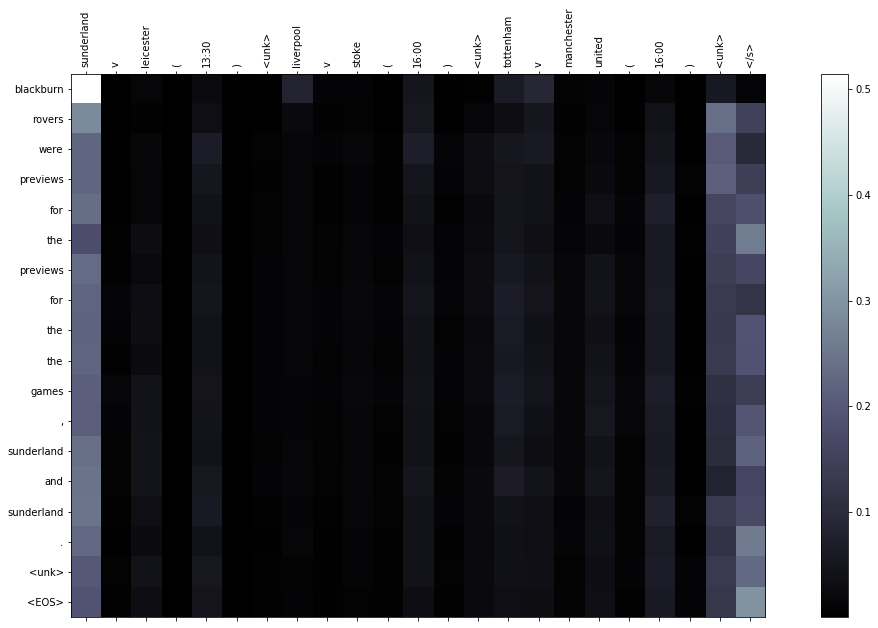

['<unk>', '</s>']
['the', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'is', 'to', 'her', 'to', 'her', 'permission', 'for', 'her', 'permission', '.', '<unk>', '<EOS>']


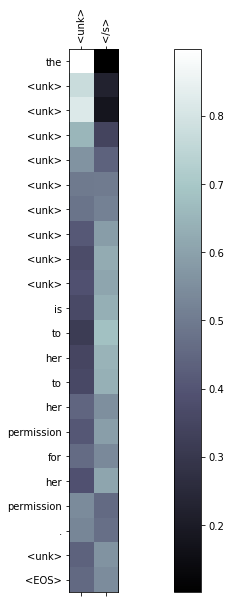

['one', 'hostage', 'survived', ',', '<unk>', 'watanabe', ',', 'who', 'also', 'worked', 'for', '<unk>', 'corp', '<unk>', '</s>']
['families', 'of', 'the', 'japanese', 'insurance', '(', '<unk>', '(', '<unk>', ')', ',', ',', ',', ',', ',', 'which', 'sank', ',', 'the', 'last', 'year', ',', 'the', 'philippines', '.', '<unk>', '<EOS>']


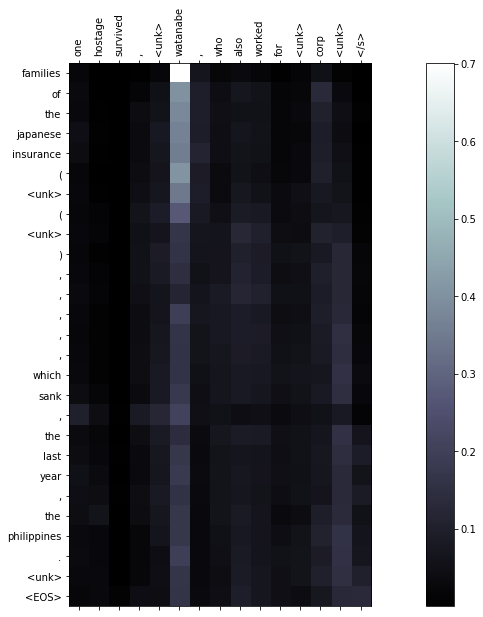

['here', 'we', 'share', 'some', 'images', 'of', 'the', 'airport', ',', 'whose', 'expansion', 'began', 'after', 'world', 'war', 'two', '.', '<unk>', '</s>']
['digital', 'digital', 'planes', 'are', 'to', 'to', 'the', 'international', 'airport', '-', 'the', 'world', '-', 'the', 'international', 'airport', '.', '<unk>', '<EOS>']


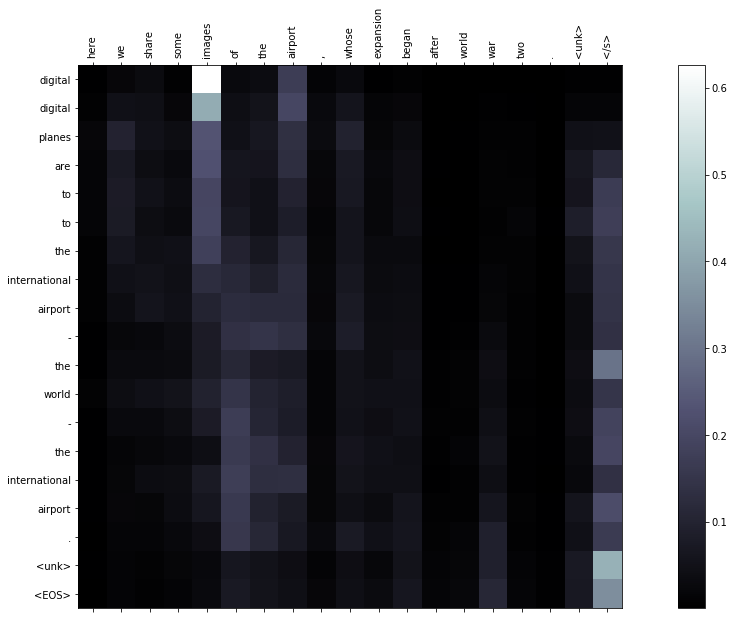

['the', 'body', 'of', 'a', 'man', 'in', 'his', '40s', 'was', 'found', 'in', 'the', '<unk>', 'cottages', 'area', 'on', 'sunday', 'night', '.', '<unk>', 'police', 'are', 'treating', 'the', 'death', 'as', 'suspicious', '.', '<unk>', '</s>']
['a', 'body', 'found', 'body', 'was', 'found', 'in', 'a', 'hotel', 'in', 'the', ',', 'the', 'body', 'of', 'a', 'man', ',', 'police', 'have', 'said', '.', '<unk>', '<EOS>']


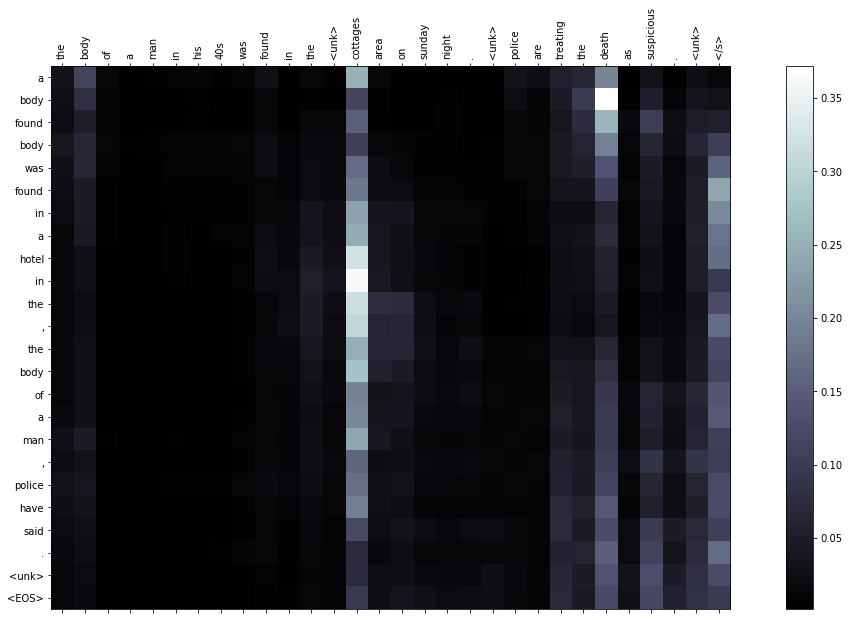

['here', "'s", 'my', 'take', '.', '<unk>', '</s>']
['sweden', "'s", 'bantamweight', '<unk>', '<unk>', 'has', 'been', 'ruled', 'out', 'of', 'the', 'appointment', 'of', 'her', 'controversial', 'appointment', 'to', '<unk>', '<EOS>']


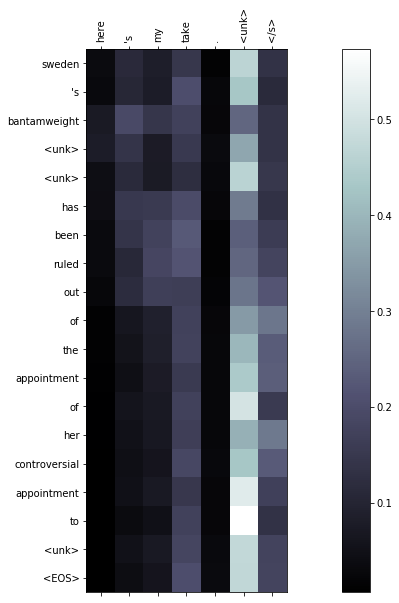

['no', 'new', 'date', 'has', 'yet', 'been', 'set', 'for', 'the', 'game', 'to', 'be', 'played', '.', '<unk>', '</s>']
['the', 'new', 'one', 'game', 'between', 'southampton', 'will', 'be', 'without', 'a', 'whole', 'saturday', "'s", 'game', 'between', 'southampton', 'and', '<unk>', '<EOS>']


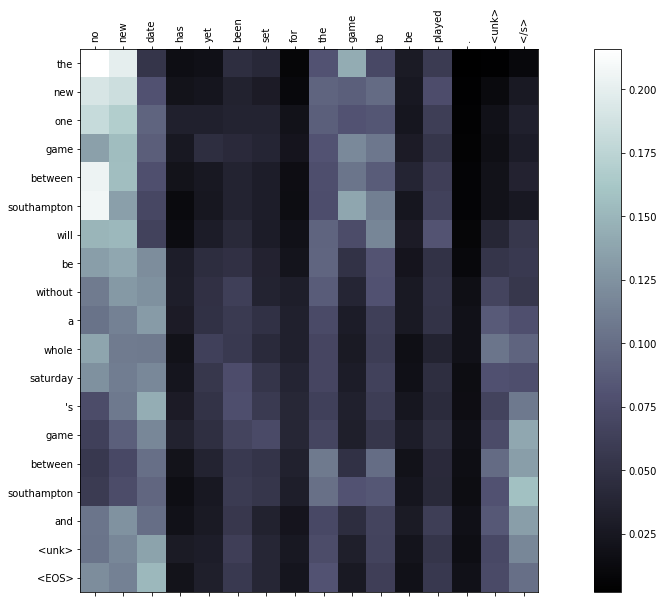

['it', 'has', 'been', 'generating', 'electricity', 'on', 'the', 'island', 'since', '1971', ',', 'employing', 'thousands', 'of', 'workers', 'since', 'work', 'began', 'on', 'construction', 'in', '1963', '.', '<unk>', '</s>']
['a', 'decades', 'ago', 'is', 'being', 'restored', 'to', 'the', 'island', 'island', 'island', 'years', 'ago', '.', '<unk>', '<EOS>']


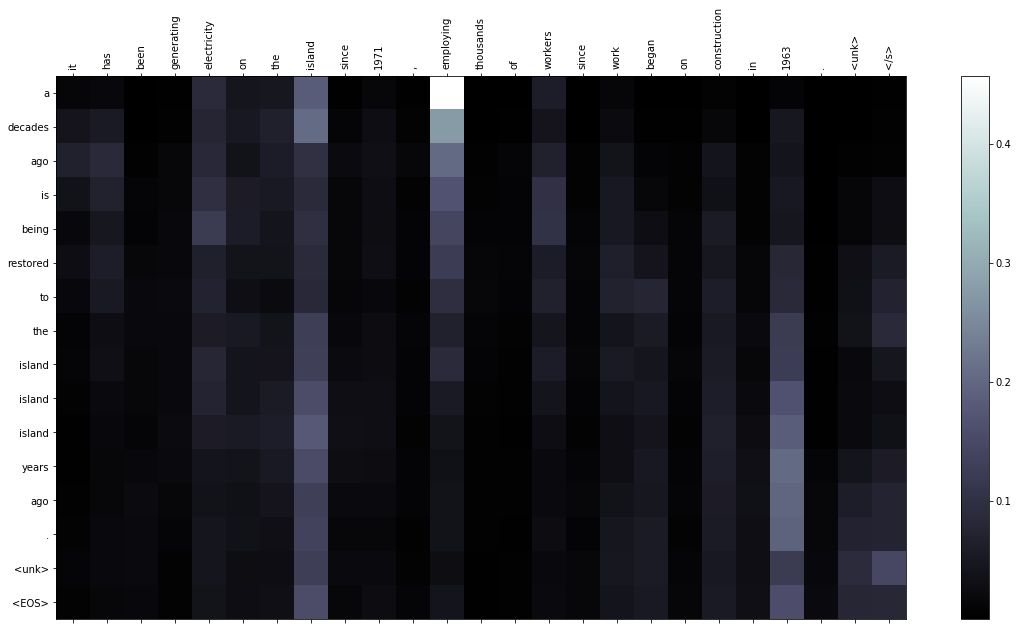

['a', 'selection', 'of', 'photos', 'from', 'across', 'the', 'african', 'continent', 'this', 'week', ':', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'afp', ',', 'epa', 'and', 'reuters', '<unk>', '<EOS>']


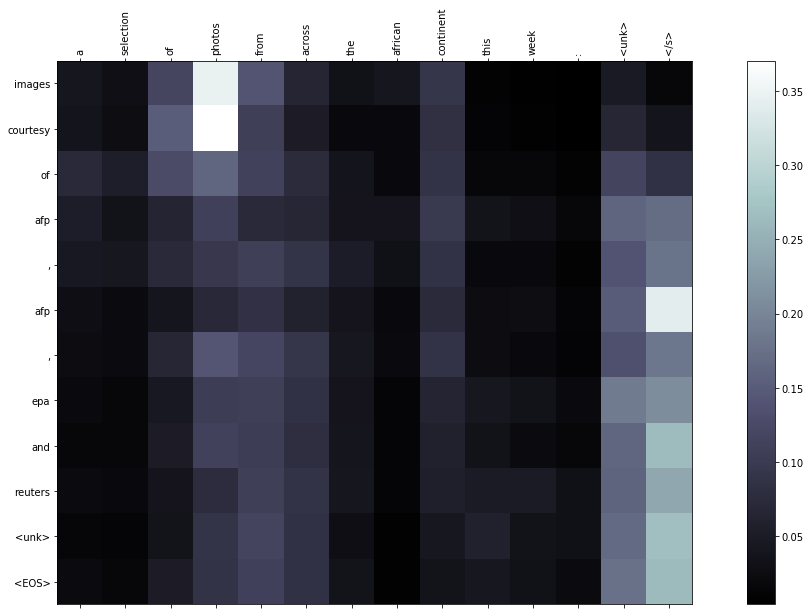

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'and', 'of', 'africans', 'elsewhere', 'in', 'the', 'world', 'this', 'week', '.', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'epa', ',', 'getty', 'images', 'and', 'reuters', '<unk>', '<EOS>']


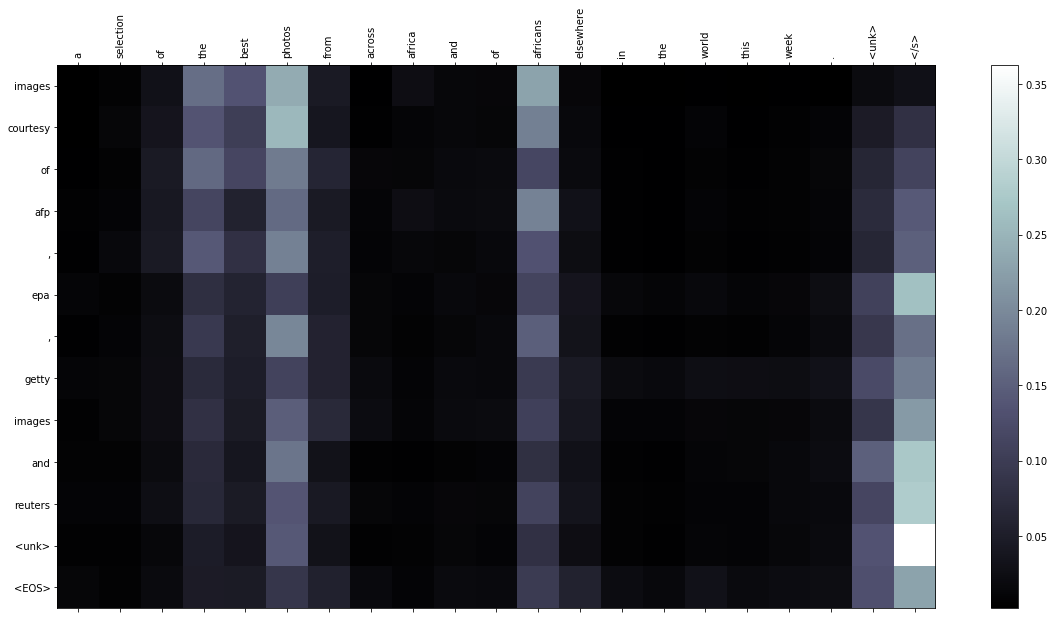

['so', 'how', 'will', 'the', 'first', 'black', 'president', 'be', 'remembered', '?', '<unk>', '</s>']
['president', 'obama', "'s", 'president', 'of', 'the', 'president', '<unk>', '<unk>', ',', '<unk>', '<EOS>']


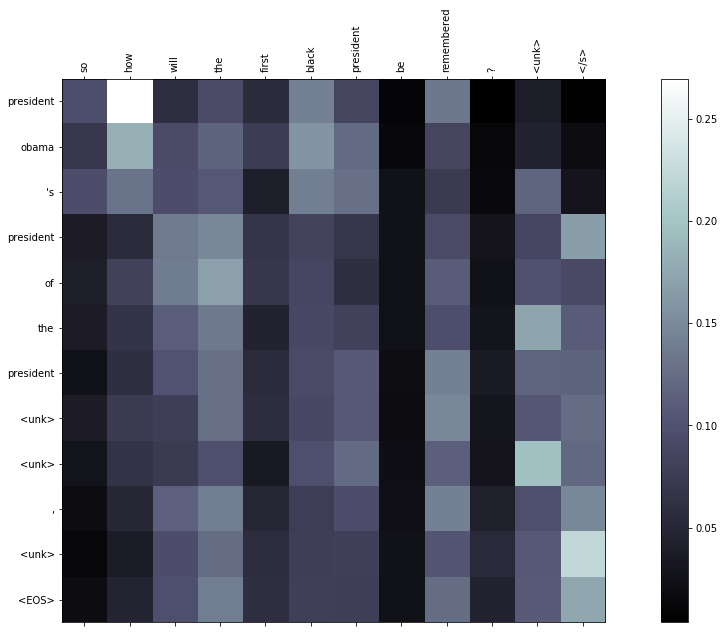

['4', 'february', '2017', 'last', 'updated', 'at', '05:32', 'gmt', '<unk>', 'video', 'journalist', ':', '<unk>', '<unk>', '<unk>', '</s>']
['nasa', 'has', 'been', 'the', 'first', 'time', 'in', 'the', 'the', 'of', 'the', '<unk>', '<EOS>']


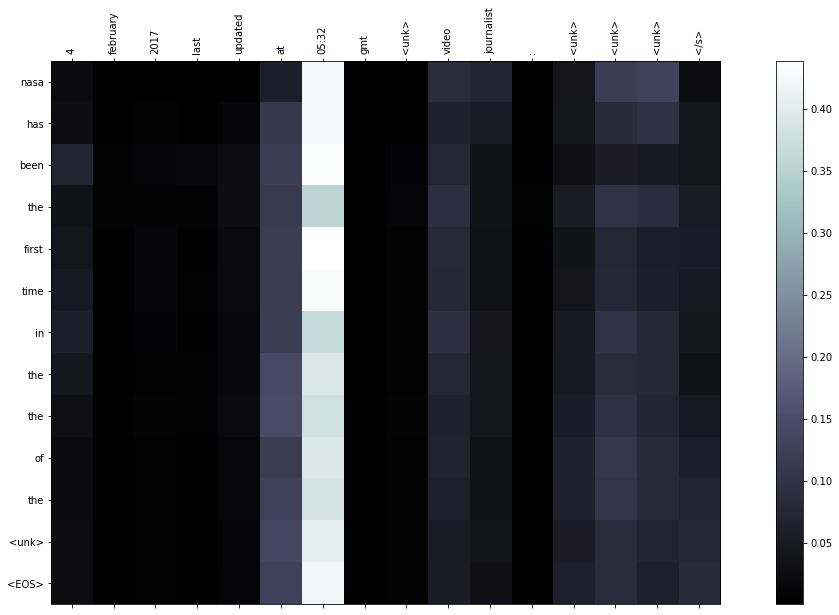

['4', 'january', '2017', 'last', 'updated', 'at', '18:52', 'gmt', '<unk>', 'bbc', 'africa', 'security', 'correspondent', 'tomi', '<unk>', 'looks', 'at', 'the', 'impact', 'they', 'have', 'had', '.', '<unk>', '</s>']
['nigeria', '’s', 'south', 'african', 'republic', 'of', 'congo', ',', 'have', 'been', 'the', 'south', 'african', 'republic', 'of', 'congo', ',', '<unk>', '<EOS>']


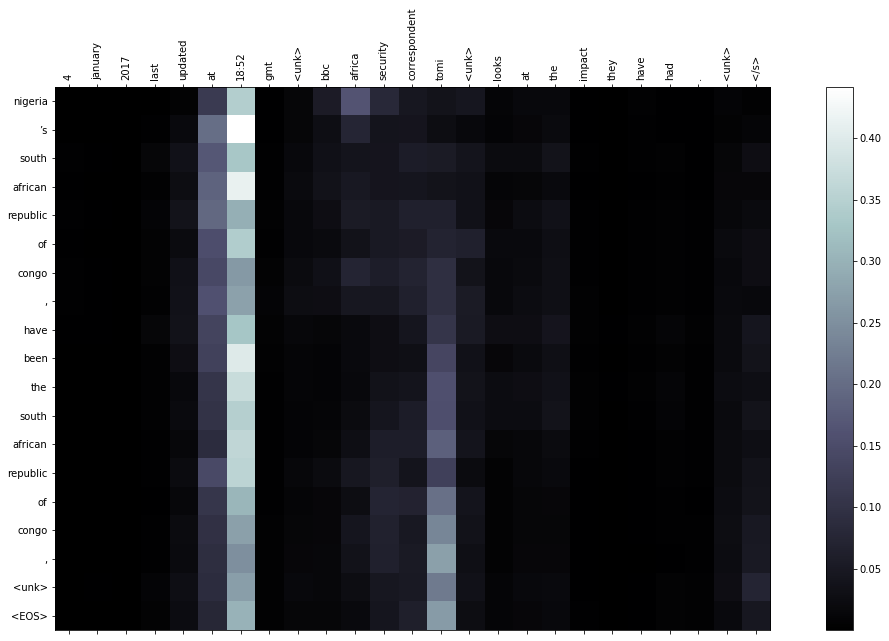

['january', '<unk>', 'february', '<unk>', 'march', '<unk>', 'april', '<unk>', 'may', '<unk>', 'june', '<unk>', '</s>']
['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<EOS>']


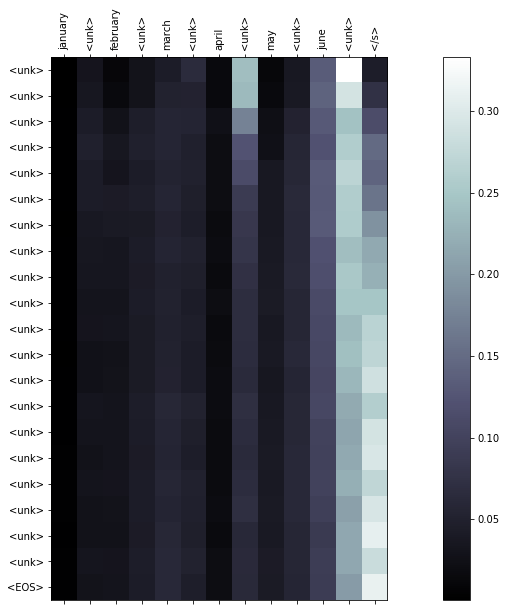

['13', 'december', '2016', 'last', 'updated', 'at', '16:25', 'gmt', '<unk>', '</s>']
['a', 'florida', 'are', 'being', 'to', 'be', 'the', 'to', 'expect', 'the', 'future', '.', '<unk>', '<EOS>']


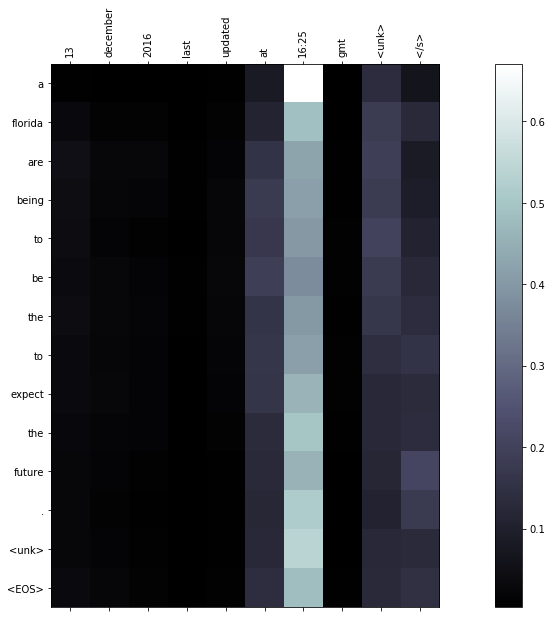

['25', 'may', '2016', 'last', 'updated', 'at', '08:35', 'bst', '<unk>', '</s>']
['mae', '<unk>', ',', 'a', 'gambling', 'and', 'jack', '<unk>', 'and', 'gambling', 'gambling', ',', 'has', 'been', 'told', 'to', 'buy', 'a', '<unk>', '.', '<unk>', '<EOS>']


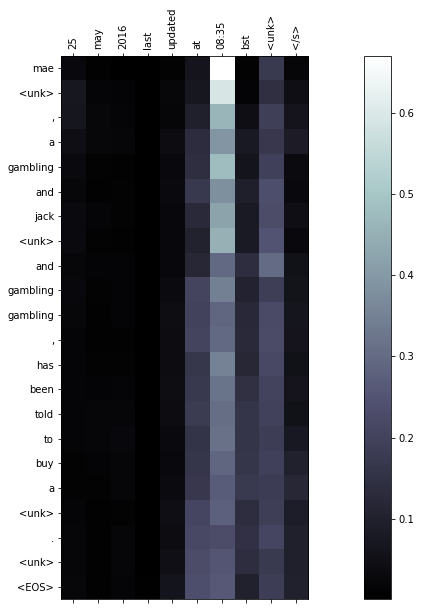

['media', 'playback', 'is', 'unsupported', 'on', 'your', 'device', '<unk>', '2', 'july', '2015', 'last', 'updated', 'at', '11:59', 'bst', '<unk>', 'the', 'footage', '-', 'courtesy', 'of', 'rizwan', 'aziz', '-', 'was', 'recorded', 'in', 'slow', 'motion', '.', '<unk>', '</s>']
['a', 'video', 'of', 'showing', 'a', 'video', 'showing', 'a', 'video', 'showing', 'the', 'electronic', 'showing', 'the', 'electronic', 'video', 'showing', 'her', 'first', 'time', 'in', 'the', 'us', '.', '<unk>', '<EOS>']


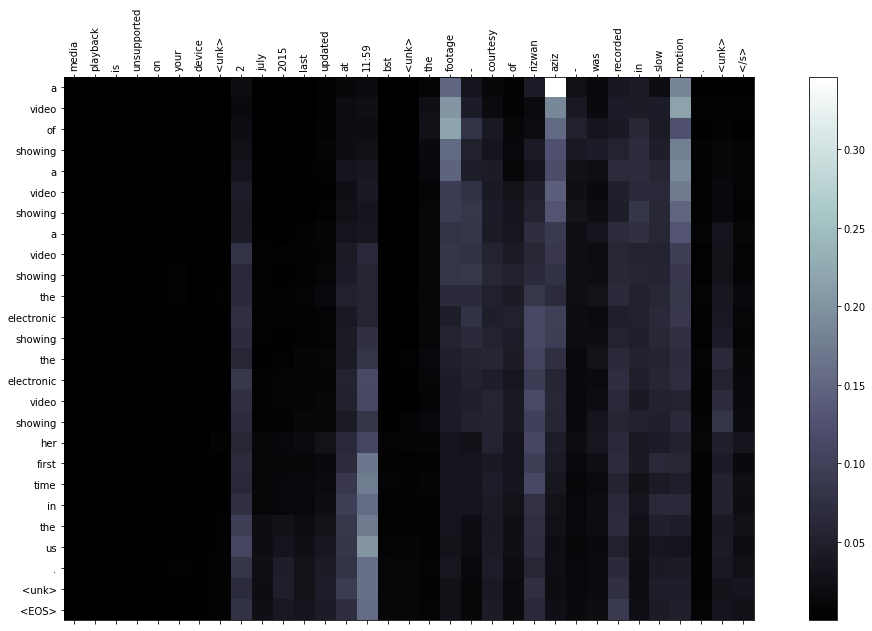

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'this', 'week', ':', '<unk>', '</s>']
['images', 'courtesy', 'of', 'ap', ',', 'epa', ',', 'getty', 'images', 'courtesy', 'of', 'afp', '.', '<unk>', '<EOS>']


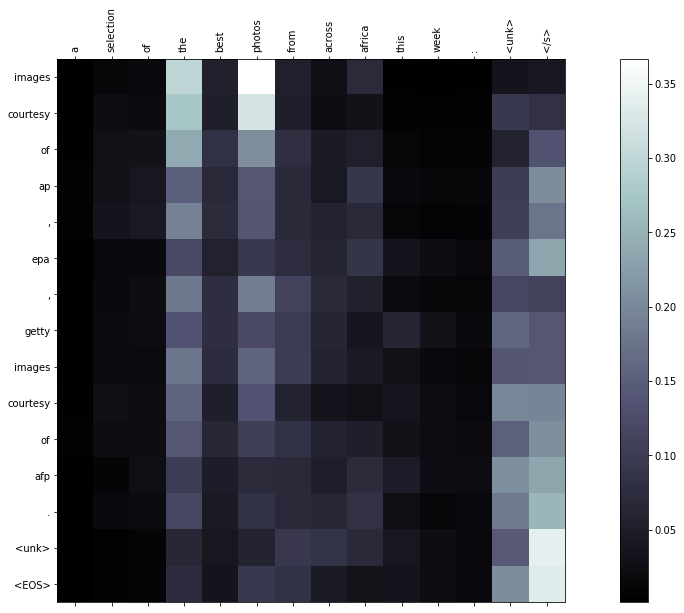

['<unk>', 'hwn', 'ar', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'yma', '<unk>', '<unk>', '<unk>', 'yn', '<unk>', '<unk>', 'ac', 'yn', 'agor', 'mewn', '<unk>', '<unk>', '<unk>', '<unk>', 'benben', 'â', '<unk>', 'cymru', '<unk>', ':', '<unk>', '</s>']
['mae', '<unk>', 'ac', '<unk>', '<unk>', 'ac', '<unk>', '<unk>', 'yng', '<unk>', '<unk>', '<unk>', 'ac', '<unk>', 'ac', '<unk>', '<unk>', '<unk>', '<unk>', 'ac', 'ac', '<unk>', '<unk>', '<unk>', 'ac', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'ac', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'ac', 'y', 'ac', '<unk>']


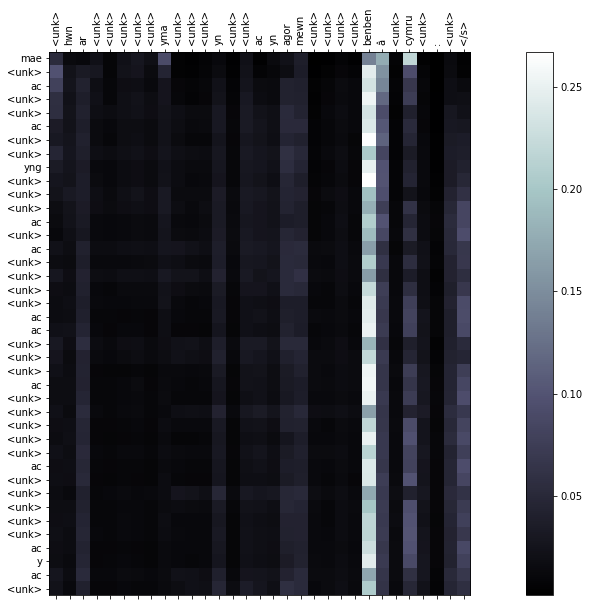

['full', 'results', 'from', 'the', 'associated', 'press', 'are', 'available', 'below', '.', '<unk>', 'georgia', '<unk>', '</s>']
['the', 'us', 'voters', 'have', 'been', 'in', 'the', 'us', 'open', 'in', 'the', 'us', '.', '<unk>', '<EOS>']


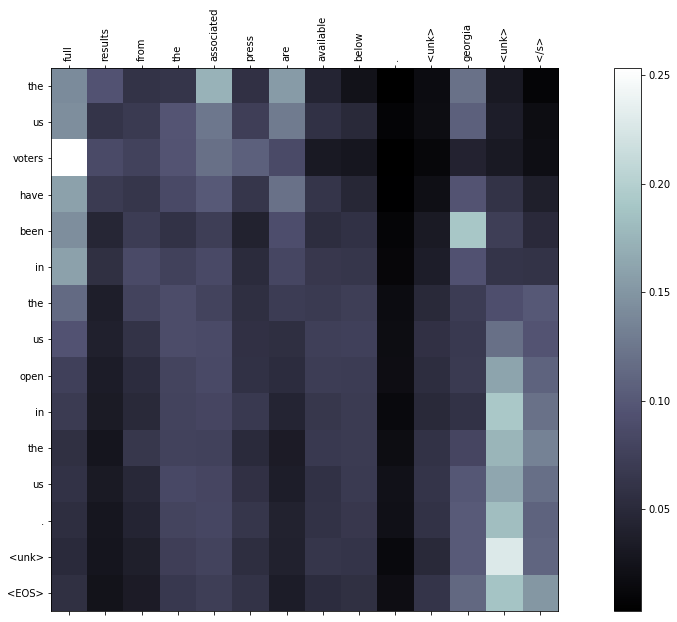

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'this', 'week', ':', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'ap', ',', 'epa', ',', 'getty', 'images', 'of', 'reuters', '<unk>', '<EOS>']


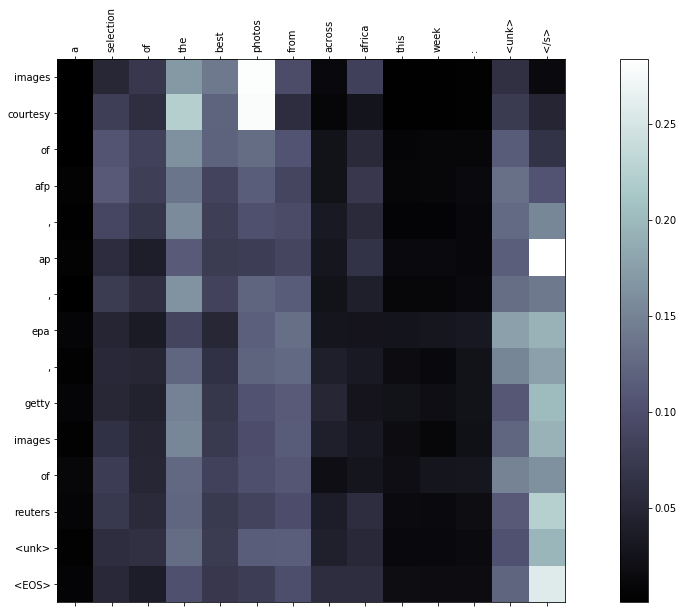

['26', 'october', '2015', 'last', 'updated', 'at', '18:27', 'gmt', '<unk>', 'so', 'it', 'matters', 'when', 'he', 'says', 'western', 'politicians', 'expected', 'too', 'much', 'of', 'central', 'bankers', 'over', 'the', 'past', 'few', 'years', ',', 'and', 'that', 'governments', 'were', 'too', 'obsessed', 'with', 'making', 'budget', 'cuts', '.', '<unk>', '</s>']
['government', 'should', 'should', 'be', 'more', 'than', 'one', 'of', 'the', 'country', "'s", 'biggest', ',', ',', ',', 'the', 'and', 'other', 'such', 'such', 'as', 'the', 'country', "'s", 'biggest', 'such', 'such', 'such', 'as', 'the', 'country', "'s", 'biggest', 'such', 'such', 'as', 'the', 'of', 'the', '.']


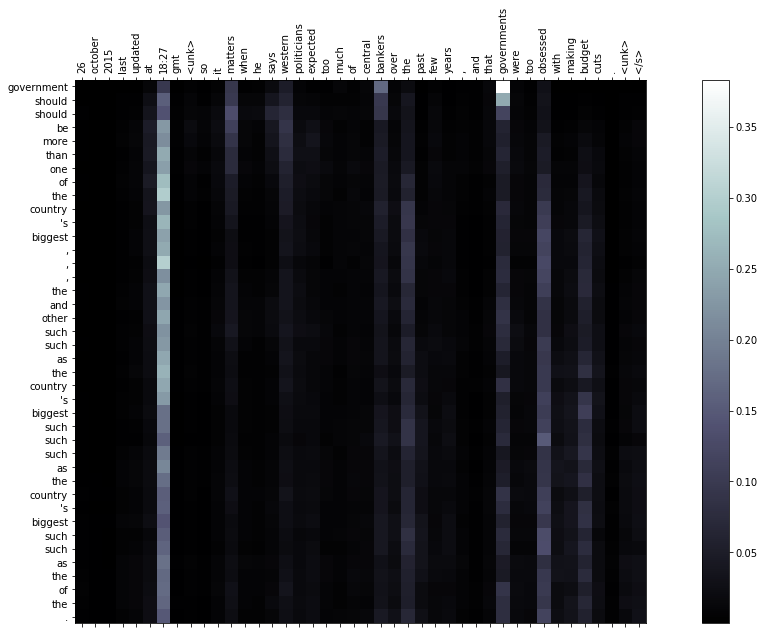

['<unk>', '</s>']
['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<EOS>']


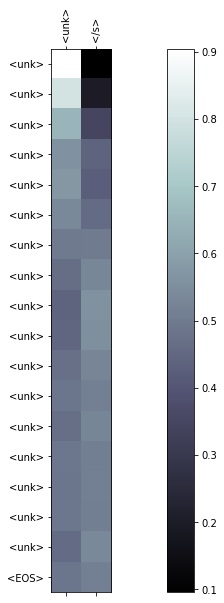

['will', 'you', 'be', 'beaten', 'about', 'the', 'bush', '?', '<unk>', 'picture', 'credits', ':', 'getty', 'images', ';', 'alamy', ';', 'google', 'street', 'view', '<unk>', '</s>']
['the', 'of', 'the', 'south', '-', 'west', 'american', 'army', 'has', 'the', 'the', 'of', 'the', "'s", '<unk>', '<EOS>']


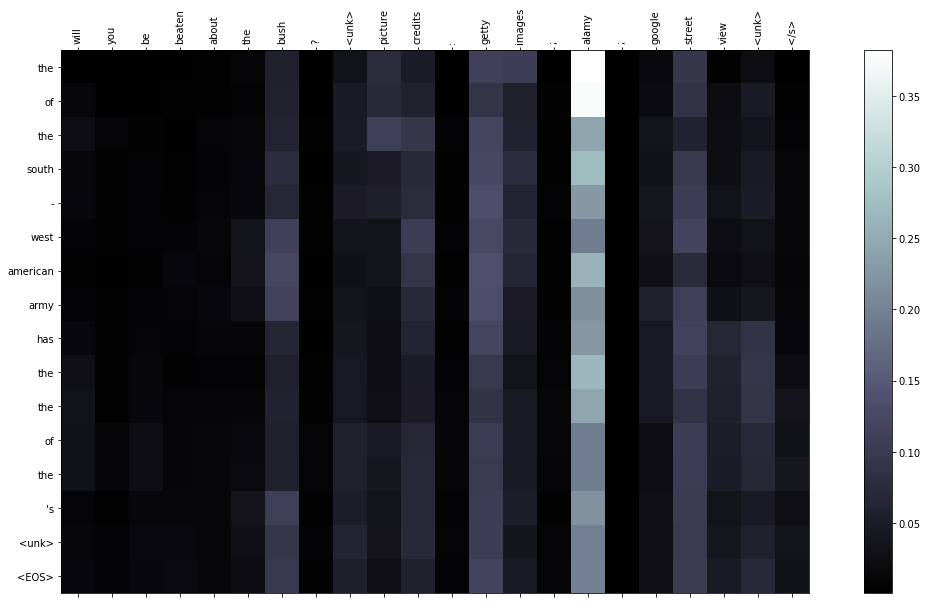

['police', 'scotland', 'said', 'it', 'followed', 'reports', 'of', 'an', 'incident', 'in', '<unk>', 'on', 'tuesday', '.', '<unk>', 'the', 'girl', 'will', 'be', 'reported', 'to', 'the', 'youth', 'justice', 'management', 'unit', '.', '<unk>', '</s>']
['a', '12-year', 'girl', 'girl', 'has', 'been', 'charged', 'with', 'the', 'rape', 'of', 'a', '14-year', '-', 'old', 'girl', 'girl', '.', '<unk>', '<EOS>']


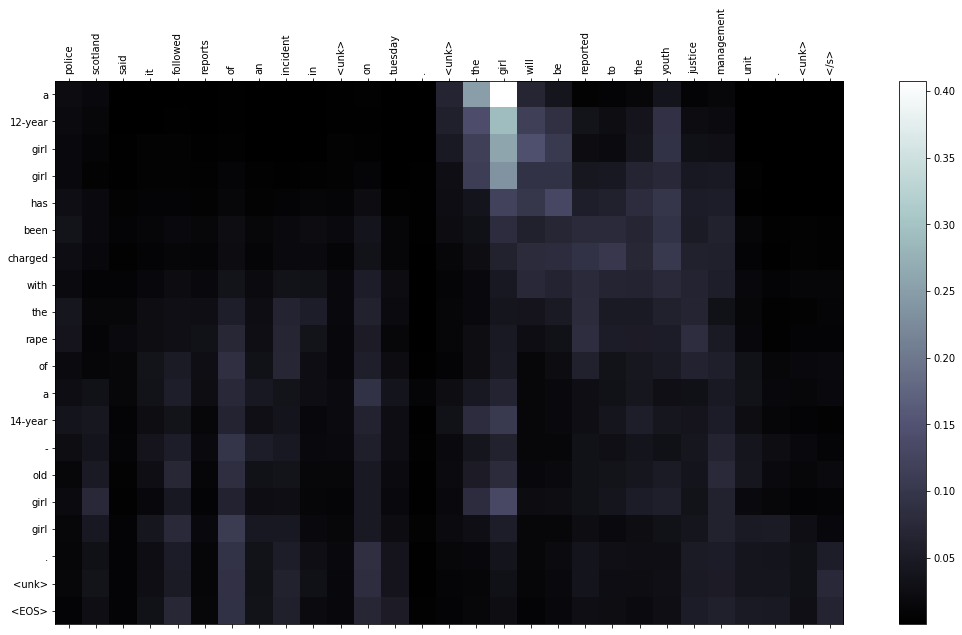

['a', 'selection', 'of', 'photos', 'from', 'across', 'the', 'african', 'continent', 'this', 'week', ':', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'ap', ',', 'epa', ',', 'reuters', '<unk>', '<EOS>']


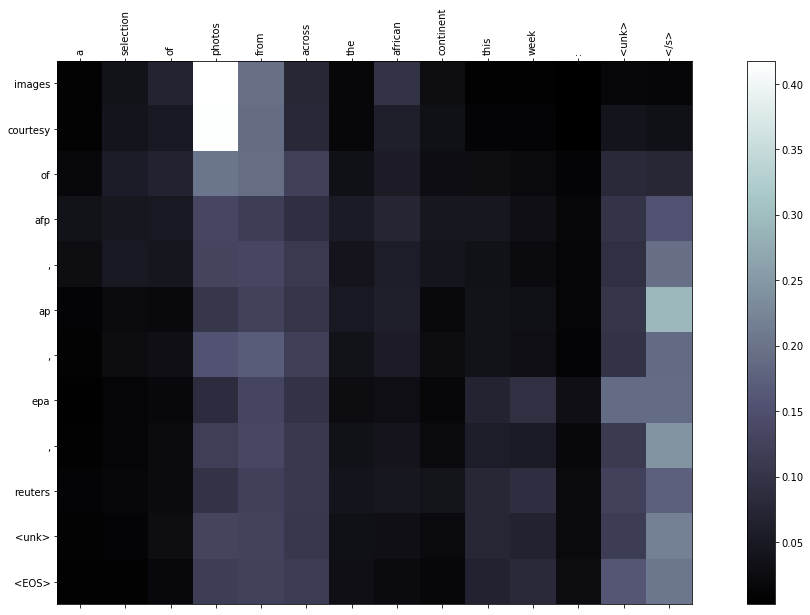

['20', 'january', '2017', 'last', 'updated', 'at', '06:56', 'gmt', '<unk>', 'check', 'back', 'every', 'friday', 'for', 'your', 'weekly', 'weird', 'round', '-', 'up', '!', '<unk>', '</s>']
['us', 'american', 'us', ',', 'american', ',', ',', 'american', ',', ',', 'the', 'us', ',', ',', ',', 'the', 'us', '.', '<unk>', '<EOS>']


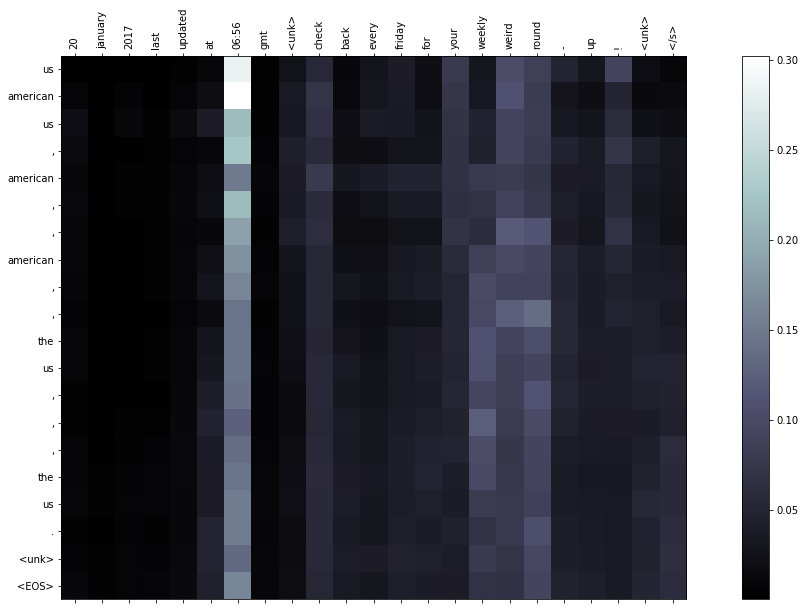

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'and', 'of', 'africans', 'elsewhere', 'in', 'the', 'world', 'this', 'week', '.', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'epa', ',', 'getty', 'images', 'and', 'reuters', '<unk>', '<EOS>']


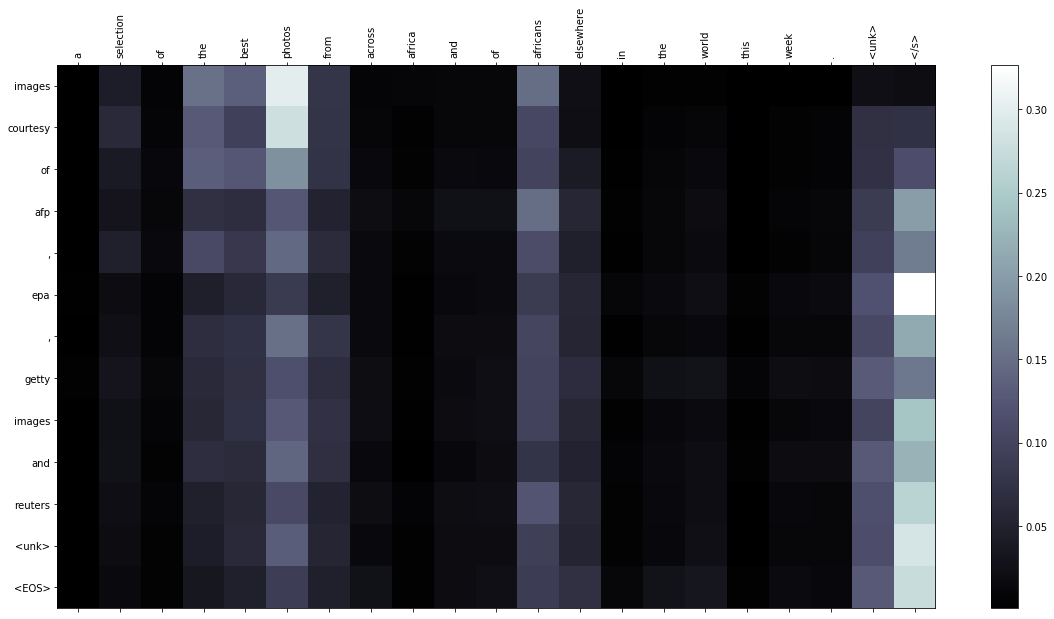

['<unk>', '</s>']
['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<EOS>']


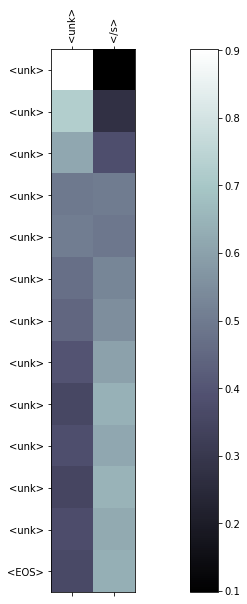

['here', 'is', 'a', 'selection', 'of', 'pictures', 'from', 'the', 'scene', '.', '<unk>', '</s>']
['photos', 'courtesy', 'of', 'video', 'star', 'cameras', 'captured', 'her', 'star', 'star', '<unk>', '<unk>', '<EOS>']


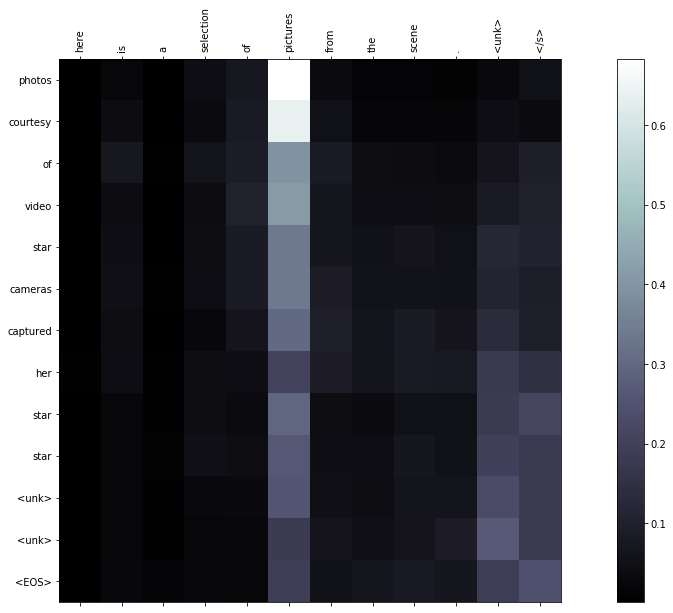

['but', 'how', 'much', 'has', 'recep', 'tayyip', 'erdogan', 'already', 'changed', 'his', 'country', '?', '<unk>', 'tap', 'here', 'to', 'find', 'out', '.', '<unk>', '</s>']
['turkey', "'s", 'turkey', "'s", 'semi', '-', 'final', 'of', 'the', 'year', "'s", 'semi', '-', 'finals', 'of', 'the', ',', ',', 'with', 'the', 'country', "'s", '<unk>', '<EOS>']


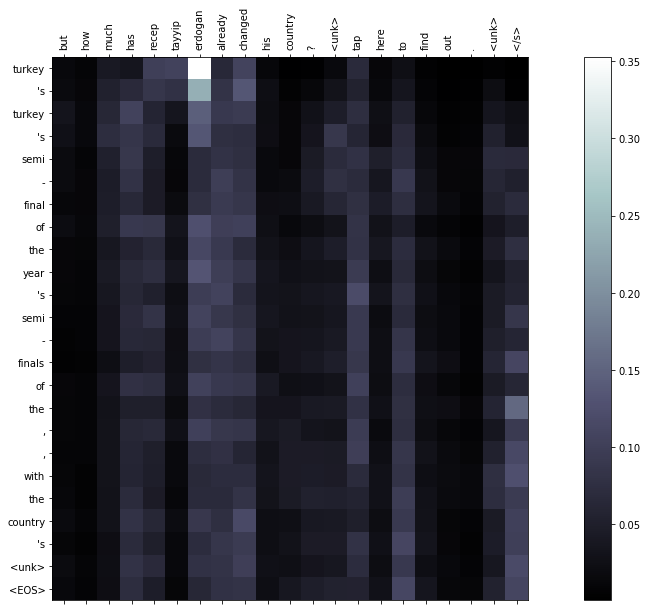

['the', '42-year', '-', 'old', 'was', 'arrested', 'in', 'the', '<unk>', 'estate', 'on', 'tuesday', 'morning', '.', '<unk>', 'he', 'was', 'taken', 'to', 'the', 'serious', 'crime', 'suite', 'in', 'antrim', 'for', 'questioning', '.', '<unk>', '</s>']
['a', 'man', 'has', 'been', 'arrested', 'in', 'the', 'murder', 'of', 'a', 'man', 'arrested', 'in', 'the', 'murder', 'of', 'a', 'property', 'in', '<unk>', '.', '<unk>', '<EOS>']


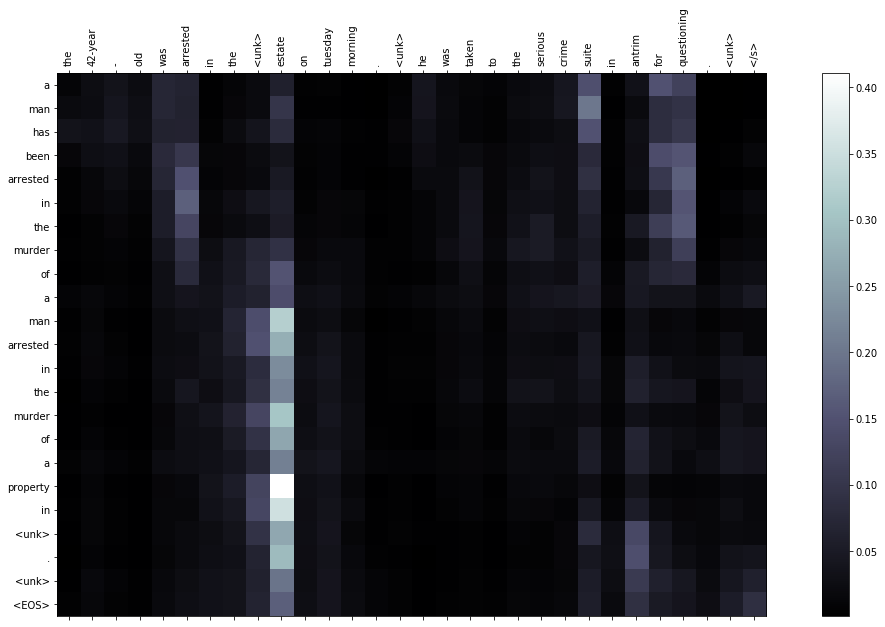

['1', 'december', '2016', 'last', 'updated', 'at', '13:09', 'gmt', '<unk>', 'steve', 'rodger', 'filmed', 'the', 'scene', 'while', 'at', 'work', 'on', 'wednesday', 'evening', 'on', 'board', 'the', 'ben', 'loyal', 'fishing', 'boat', '.', '<unk>', '</s>']
['a', 'man', 'has', 'been', 'off', 'the', 'of', 'a', 'seas', 'off', 'the', 'off', 'of', 'the', 'seas', 'of', 'of', 'the', 'off', 'the', 'death', 'of', 'a', 'teenage', 'boy', 'who', 'went', 'on', 'the', '.', '<unk>', '<EOS>']


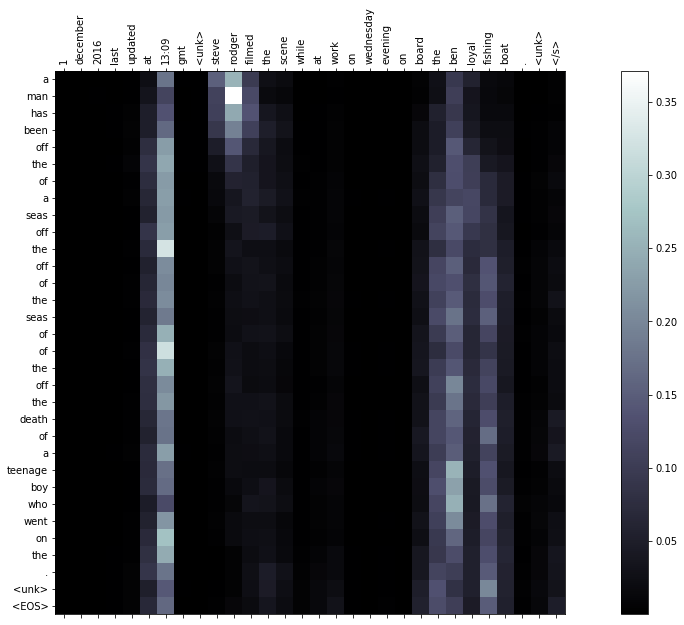

['7', 'january', '2017', 'last', 'updated', 'at', '17:08', 'gmt', '<unk>', 'it', 'is', 'the', 'oldest', 'church', 'with', 'this', 'number', 'of', 'bells', 'in', 'the', 'uk', '.', 'twelve', 'bell', 'ringers', 'recreated', 'the', 'historical', 'chimes', 'from', '1767', '.', '<unk>', '</s>']
['the', 'first', 'time', 'of', 'the', 'the', 'of', 'the', 'world', "'s", 'most', 'famous', ',', 'is', 'the', 'the', 'of', 'the', 'world', "'s", 'most', 'famous', 'history', '.', '<unk>', '<EOS>']


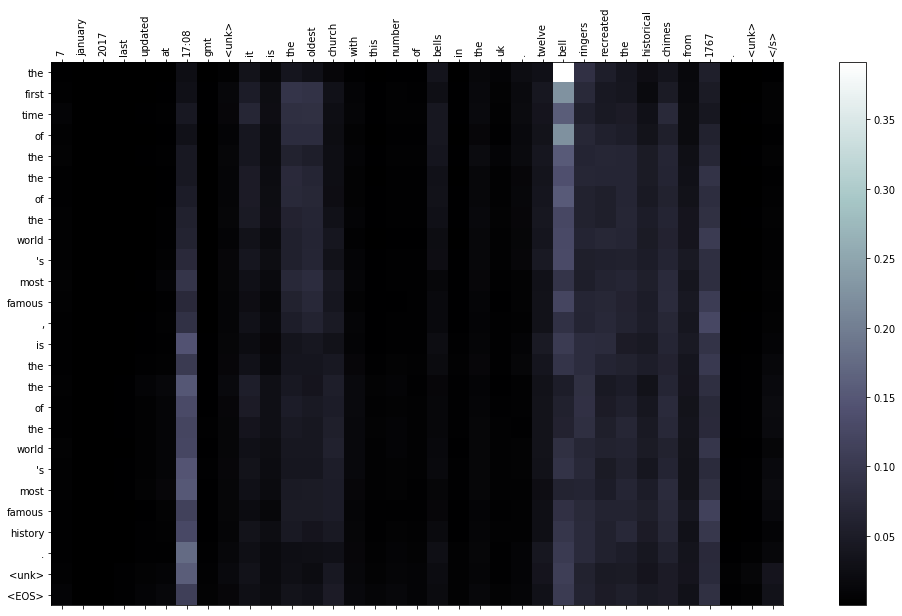

['<unk>', '</s>']
['a', '<unk>', '<unk>', '<unk>', '<EOS>']


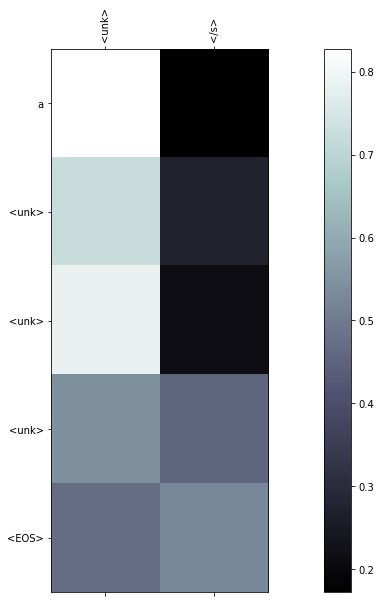

['police', 'scotland', 'said', 'the', 'incident', 'was', 'reported', 'at', 'about', '17:30', '.', '<unk>', 'members', 'of', 'the', 'coastguard', 'are', 'involved', 'in', 'the', 'search', '.', '<unk>', '</s>']
['a', 'search', 'has', 'been', 'launched', 'after', 'a', 'body', 'was', 'found', 'missing', 'from', 'a', 'coastguard', '.', '<unk>', '<EOS>']


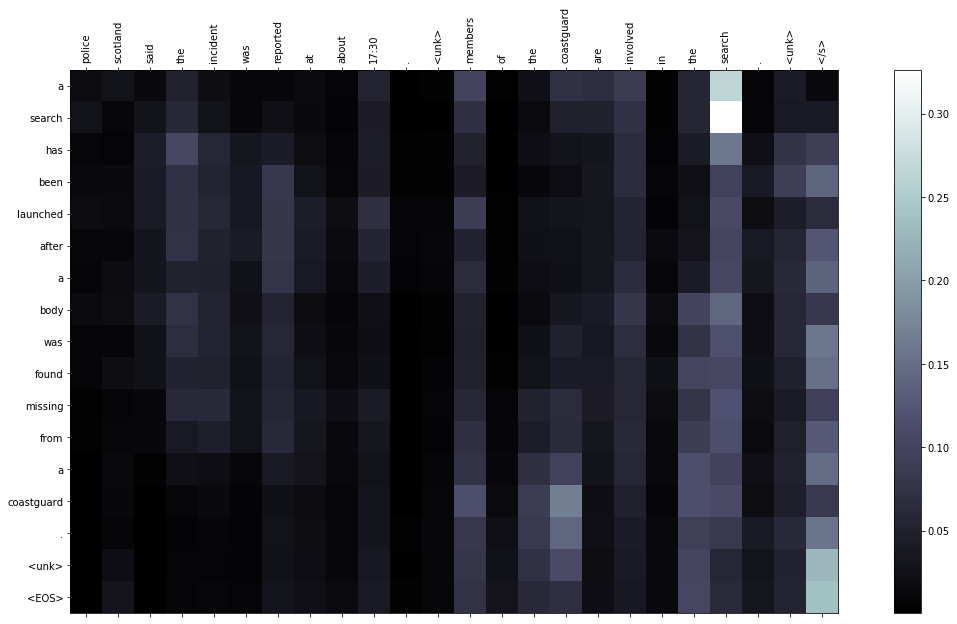

['these', 'tracks', 'were', 'chosen', 'by', 'drivers', 'and', 'bbc', 'sport', 'users', '.', '<unk>', 'read', 'more', 'about', 'bbc', 'music', 'day', 'here', '.', '<unk>', '</s>']
['bbc', 'sport', 'tracks', 'have', 'headed', 'up', 'on', 'the', 'tracks', 'tracks', 'and', 'tracks', 'tracks', 'got', 'tracks', 'across', 'the', '.', '<unk>', '<EOS>']


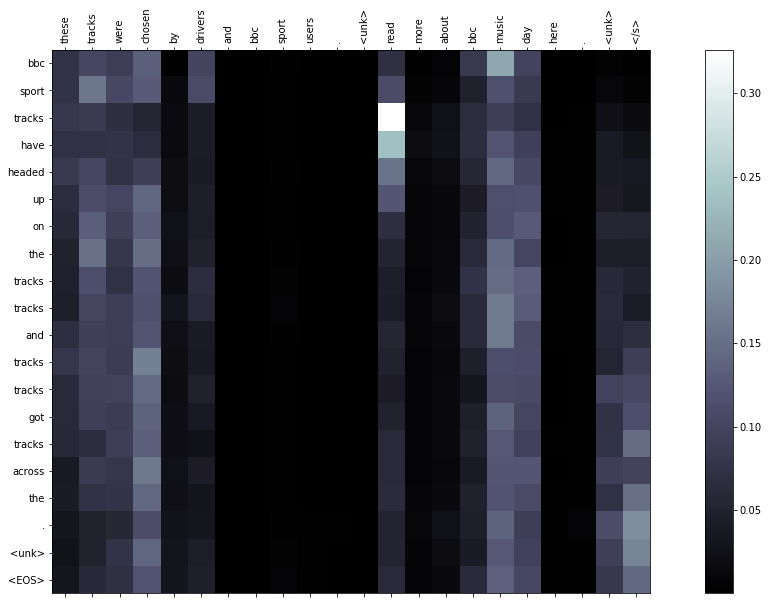

['20', 'december', '2016', 'last', 'updated', 'at', '08:42', 'gmt', '<unk>', 'here', 'they', 'are', 'telling', 'us', 'their', 'favourite', 'things', 'about', 'christmas', '.', '<unk>', '</s>']
['a', 'us', 'from', 'the', 'us', 'and', 'us', 'fashion', 'fashion', 'fashion', 'chain', 'fashion', 'fashion', 'chain', 'has', 'been', 'up', 'to', 'the', 'us', '.', '<unk>', '<EOS>']


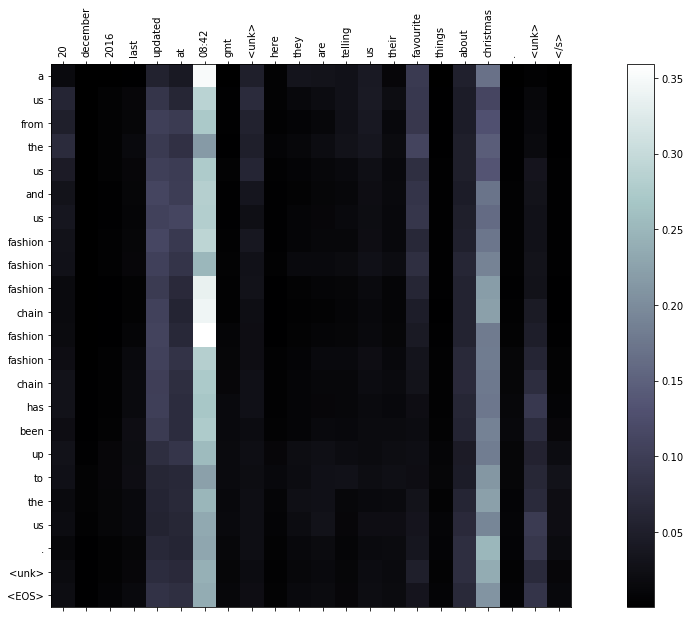

['23', 'march', '2016', 'last', 'updated', 'at', '11:46', 'gmt', '<unk>', 'the', 'silence', 'ended', 'with', 'applause', '.', '<unk>', 'three', 'days', 'of', 'national', 'mourning', 'have', 'also', 'been', 'announced', '.', '<unk>', '</s>']
['the', 'friday', "'s", 'silence', 'silence', 'silence', 'silence', 'silence', 'silence', 'silence', 'led', 'to', 'the', 'the', 'silence', 'of', 'the', 'to', 'reach', 'the', 'the', 'funeral', 'of', 'baroness', "'", '.', "'", 'silence', '.', '<unk>', '<EOS>']


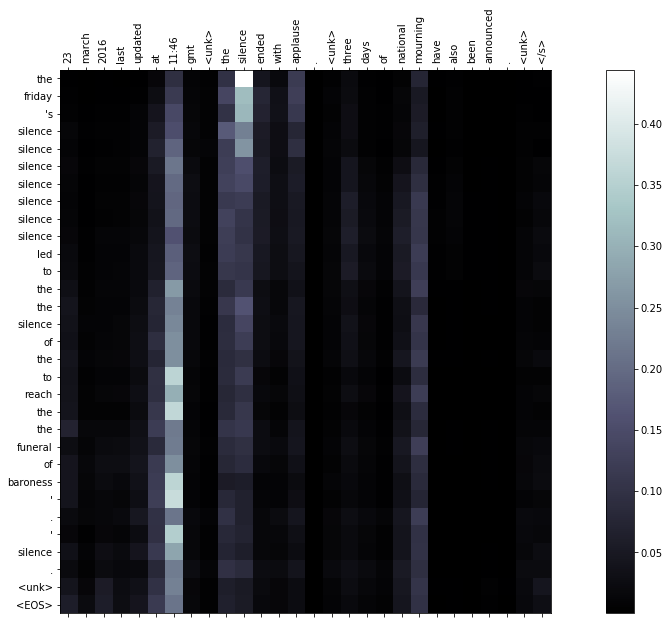

['british', 'sugar', 'began', 'growing', 'a', '<unk>', '<unk>', '</s>']
['the', '<unk>', 'giant', '<unk>', 'has', '<unk>', '<EOS>']


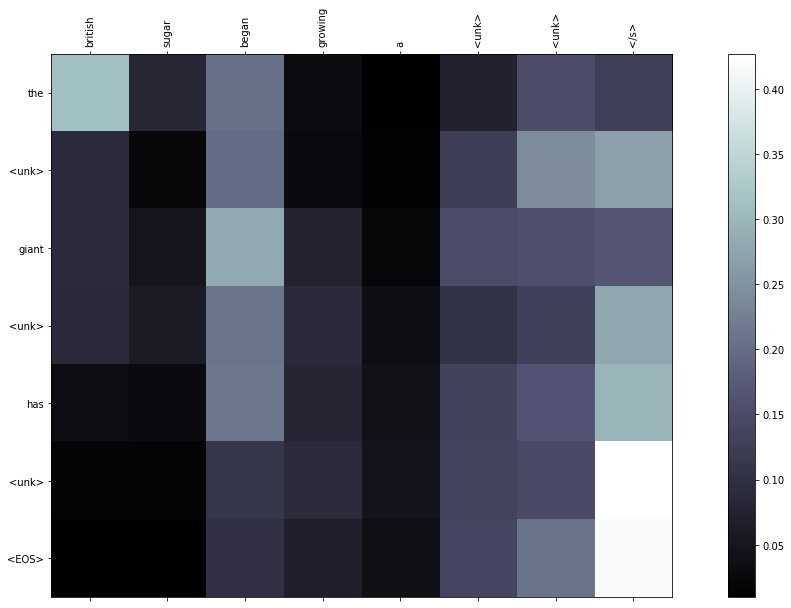

['16', 'february', '2015', 'last', 'updated', 'at', '20:47', 'gmt', '<unk>', 'it', 'is', 'backed', 'by', 'bbc', 'presenter', 'colin', 'bloomfield', 'who', 'was', 'diagnosed', 'with', 'melanoma', 'and', 'is', 'still', 'battling', 'the', 'disease', '.', '<unk>', '</s>']
['a', 'bbc', 'bbc', 'radio', 'has', 'has', 'been', 'has', 'been', 'the', 'bbc', 'the', 'most', 'of', 'the', 'most', 'expensive', '"', 'most', 'expensive', '"', '.', '<unk>', '<EOS>']


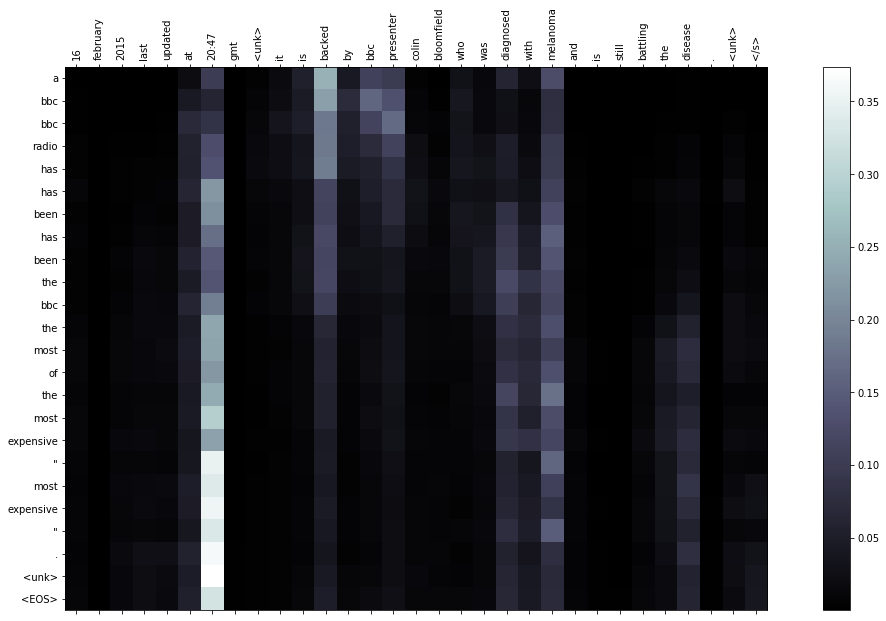

['19', 'december', '2016', 'last', 'updated', 'at', '11:48', 'gmt', '<unk>', 'it', 'happened', 'ahead', 'of', 'a', 'statement', 'by', 'the', 'dup', 'leader', 'on', 'a', 'botched', 'heating', 'scheme', '.', '<unk>', '</s>']
['arlene', 'foster', 'has', 'said', 'she', 'is', 'not', 'to', "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'", "'"]


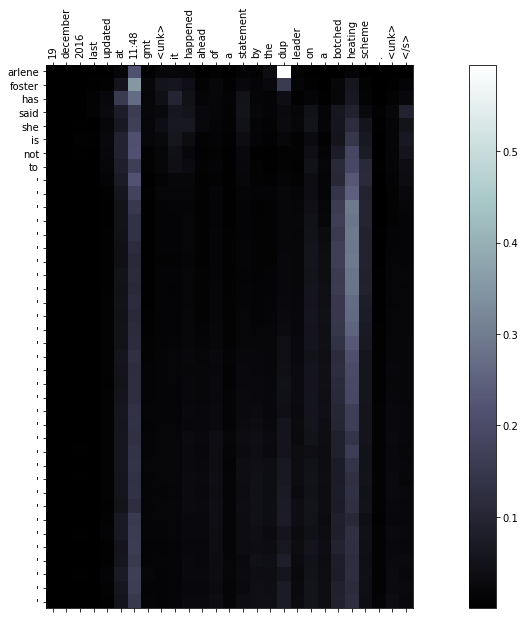

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'and', 'of', 'africans', 'elsewhere', 'in', 'the', 'world', 'this', 'week', '.', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'epa', ',', 'getty', 'images', 'and', 'reuters', '<unk>', '<EOS>']


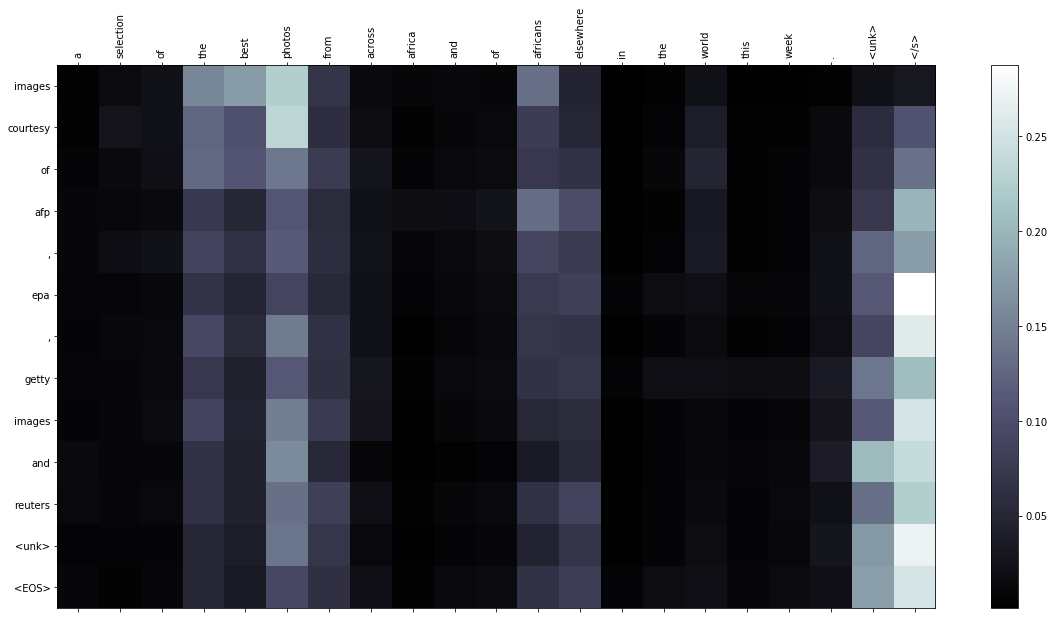

['tap', 'here', 'to', 'find', 'out', 'more', 'about', 'what', 'happened', 'when', 'the', '<unk>', 'tower', 'caught', 'fire', '<unk>', '</s>']
['tower', 'fire', 'fire', 'engulfed', 'the', 'top', 'of', 'the', 'tower', 'fire', 'tower', 'fire', '.', '<unk>', '<EOS>']


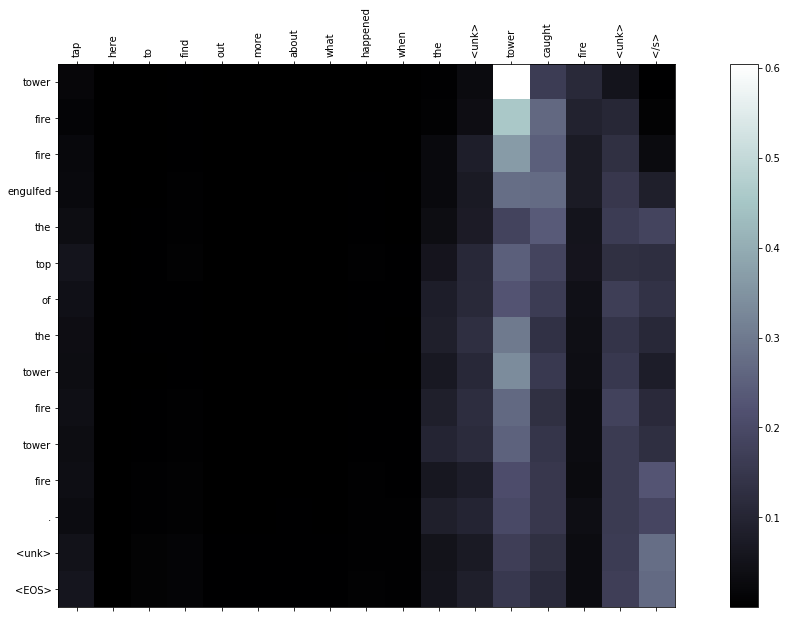

['27', 'march', '2016', 'last', 'updated', 'at', '16:47', 'bst', '<unk>', 'he', 'explained', 'how', 'he', 'made', 'the', 'show', "'s", 'main', 'character', 'berk', 'in', 'a', 'bbc', 'documentary', 'in', '1989', '.', '<unk>', '</s>']
['one', 'of', 'the', 'bbc', 'one', 'of', 'the', 'bbc', 'one', '-', 'the', 'world', "'s", 'longest', '-', ',', 'bbc', 'one', '-', '<unk>', '<EOS>']


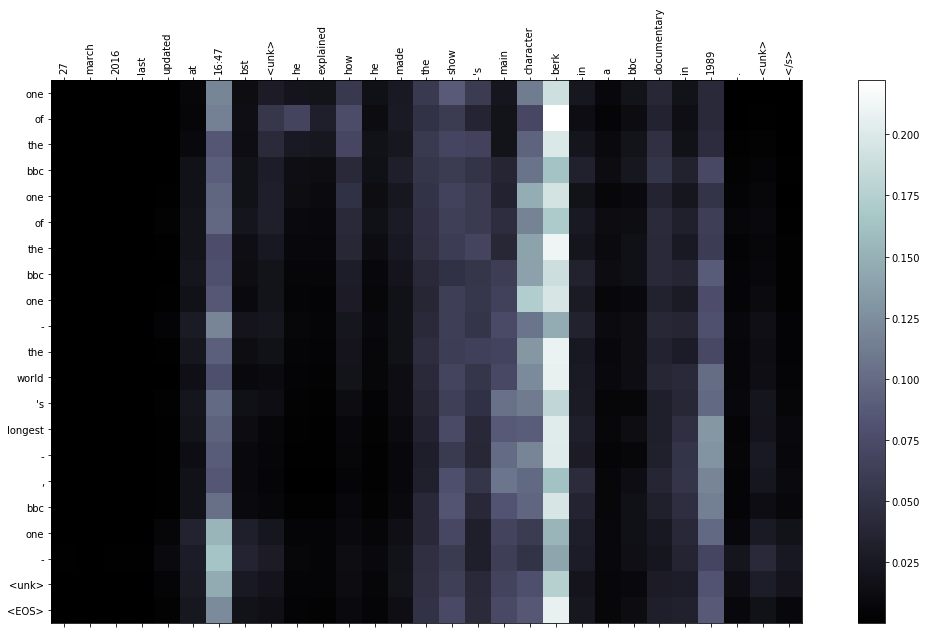

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'and', 'of', 'africans', 'elsewhere', 'in', 'the', 'world', 'this', 'week', '.', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'epa', ',', 'getty', 'images', 'and', 'reuters', '<unk>', '<EOS>']


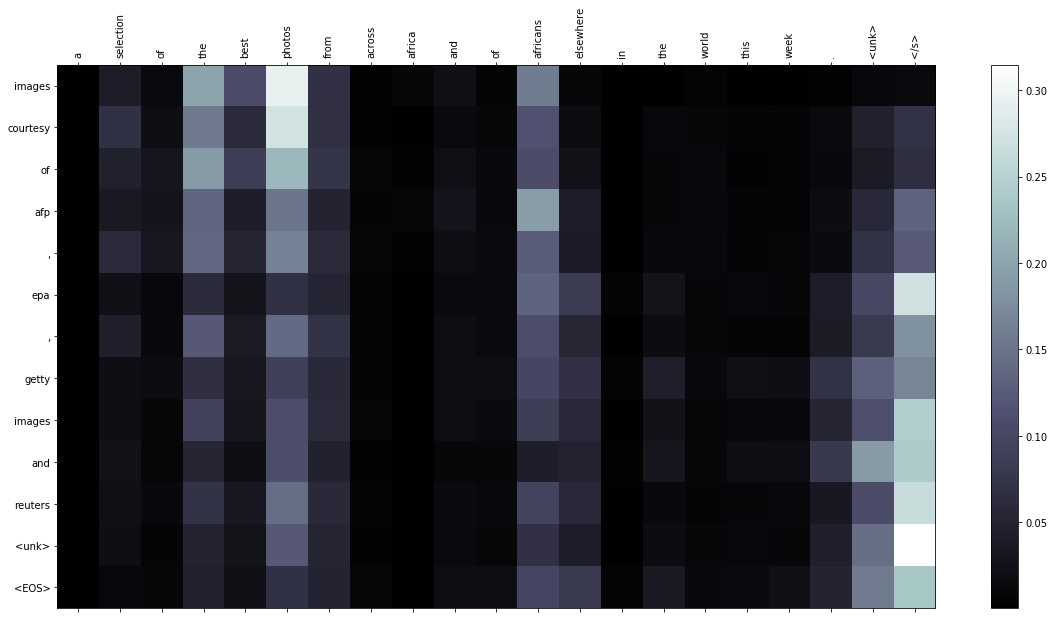

['29', 'august', '2013', 'last', 'updated', 'at', '16:05', 'bst', '<unk>', 'it', 'was', 'ranked', 'top', 'as', 'part', 'of', 'the', 'charity', "'s", '"', 'the', 'great', 'british', 'walk', '"', 'festival', '.', '<unk>', '</s>']
['a', 'charity', 'charity', 'has', 'been', 'the', '<unk>', 'of', 'the', 'british', 'british', ',', ',', 'has', 'been', 'shot', 'at', 'the', 'event', 'in', '<unk>', '.', '<unk>', '<EOS>']


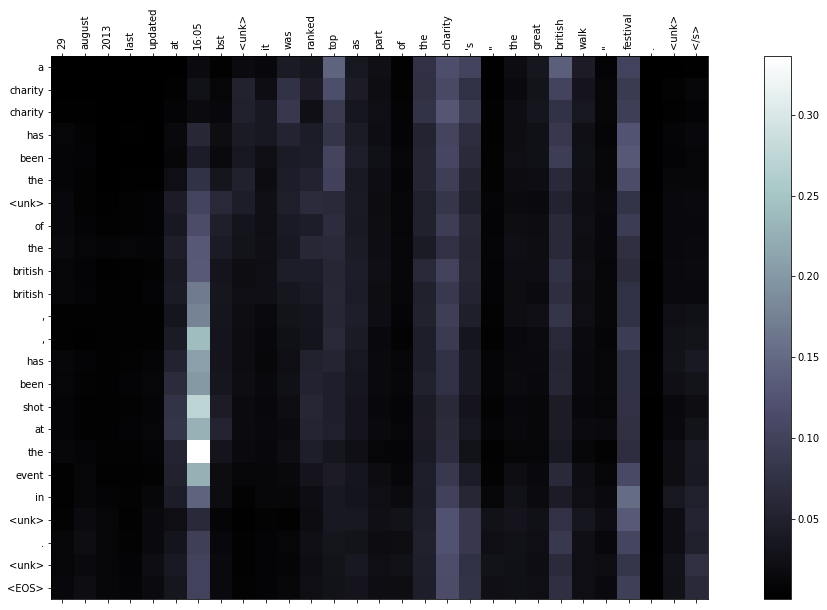

['follow', 'us', 'on', 'facebook', ',', 'on', 'twitter', '<unk>', ',', 'or', 'on', 'instagram', 'at', '<unk>', '.', 'if', 'you', 'have', 'a', 'story', 'suggestion', 'email', '<unk>', '.', '<unk>', '</s>']
['a', 'us', ',', 'the', 'us', 'twitter', ',', 'kiev', ',', '<unk>', ',', 'have', 'been', 'sent', 'to', 'a', '<unk>', '<EOS>']


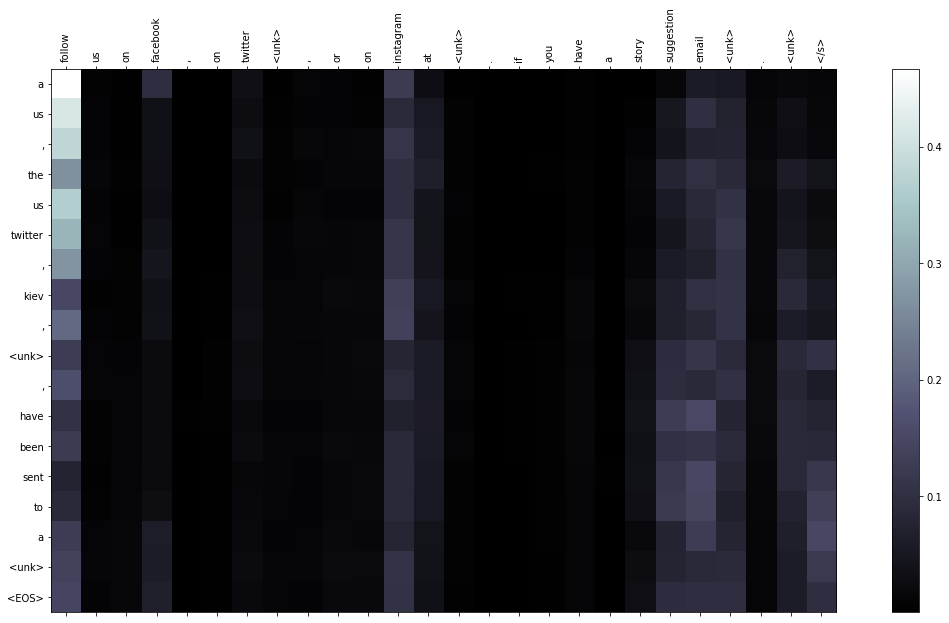

['the', 'flight', 'was', 'from', 'aberdeen', 'to', 'wick', '.', '<unk>', 'more', 'follows', '.', '<unk>', '</s>']
['a', 'light', 'aircraft', 'has', 'landed', 'on', 'a', 'aberdeen', 'airport', 'for', 'aberdeen', 'to', 'be', 'a', 'by', 'the', 'us', '.', '<unk>', '<EOS>']


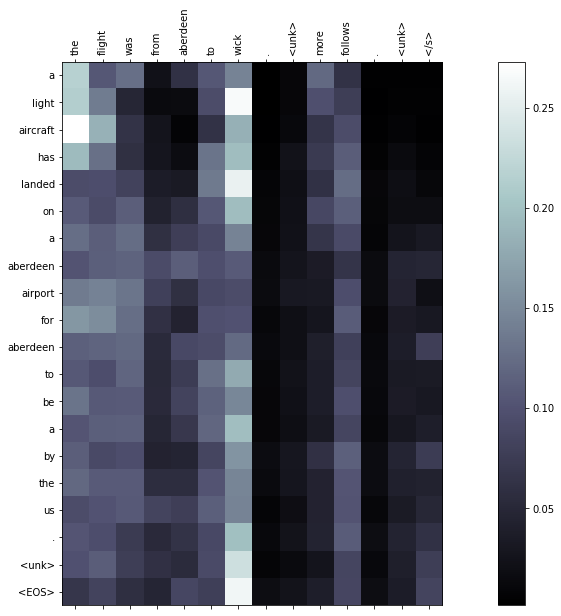

['media', 'playback', 'is', 'not', 'supported', 'on', 'this', 'device', '<unk>', 'here', "'s", 'their', 'fantastic', 'performance', 'of', "'", 'you', 'stole', 'the', 'sun', 'from', 'my', 'heart', "'", 'in', 'full', '.', '<unk>', '</s>']
['queen', "'s", 'dramatic', 'dramatic', '-', 'but', 'it', 'gave', 'them', 'a', 'dramatic', '£', '3', '-', '0', 'at', 'the', 'queen', "'s", '.', '<unk>', '<EOS>']


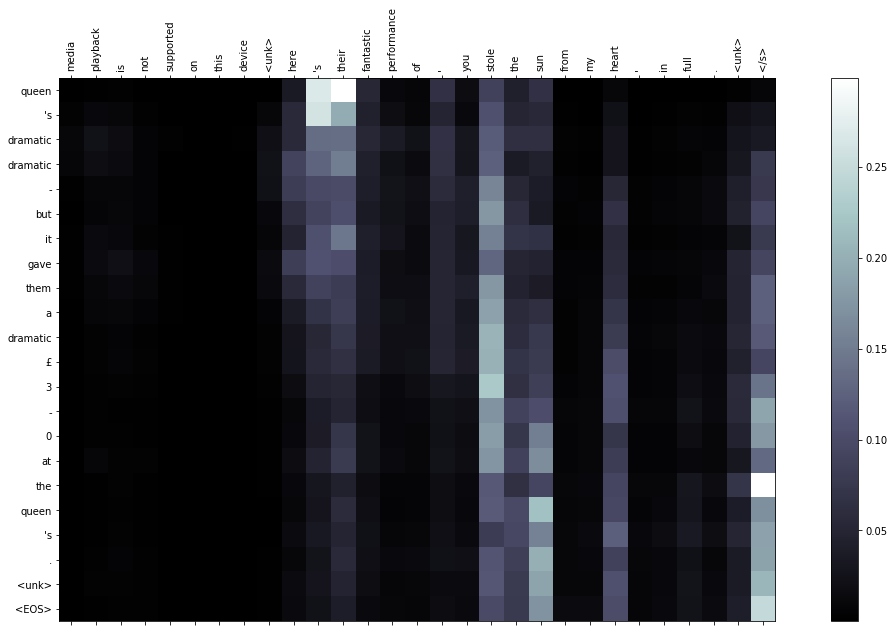

['read', 'more', 'in', 'our', 'methodology', '.', '<unk>', '</s>']
['cristiano', 'ronaldo', 'might', 'still', 'like', 'a', 'successor', 'as', 'their', 'test', 'test', 'in', 'the', 'top', 'test', 'tests', '.', '<unk>', '<EOS>']


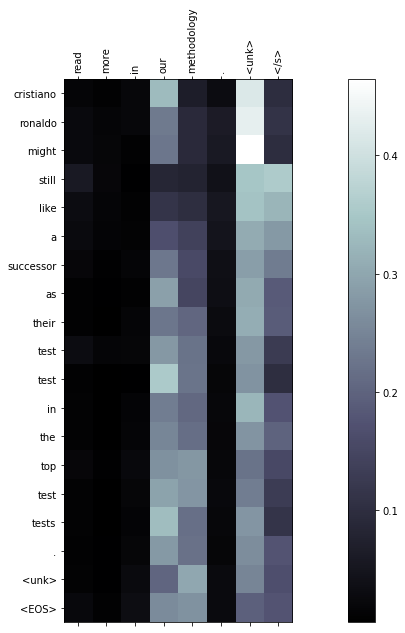

['the', 'pair', 'had', 'to', 'be', 'cut', 'free', 'from', 'the', 'wreckage', '.', '<unk>', 'the', 'crash', 'happened', 'near', '<unk>', 'just', 'before', 'midday', '.', '<unk>', '</s>']
['a', 'couple', 'were', 'killed', 'when', 'a', 'car', 'crashed', 'crashed', 'in', 'a', 'crash', 'in', 'aberdeenshire', '.', '<unk>', '<EOS>']


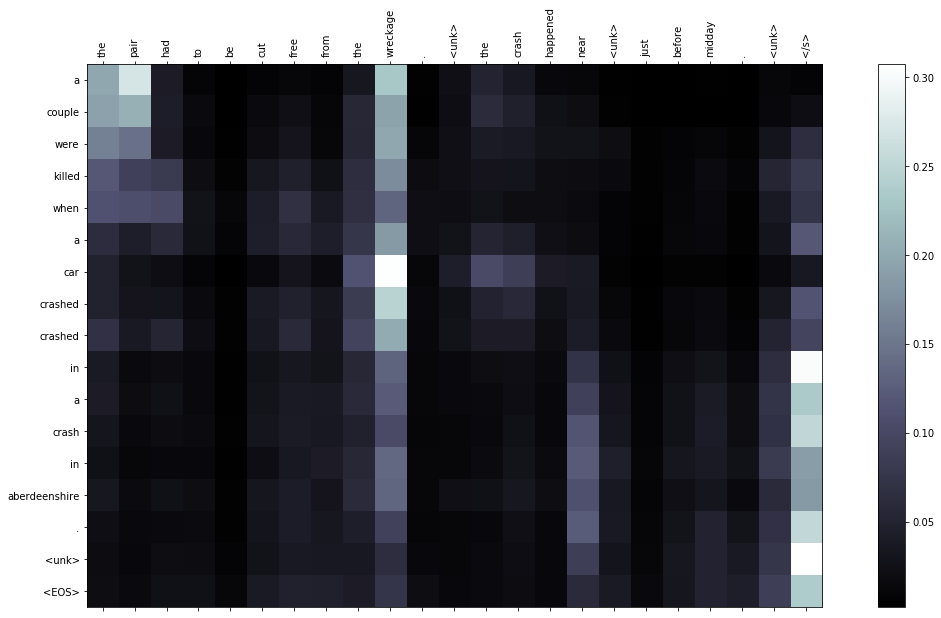

['6', 'september', '2016', 'last', 'updated', 'at', '17:09', 'bst', '<unk>', 'instruments', 'and', 'lessons', 'are', 'expensive', ',', 'but', 'after', 'seeing', 'their', 'talent', ',', 'their', 'father', 'decided', 'to', 'teach', 'them', 'himself', '.', '<unk>', '</s>']
['a', 'school', 'who', 'were', 'a', 'to', 'sign', 'telling', 'they', "'re", 'ca', "n't", "n't", 'ca', "n't", "n't", "n't", 'ca', "n't", "n't", 'like', 'a', '.', '<unk>', '<EOS>']


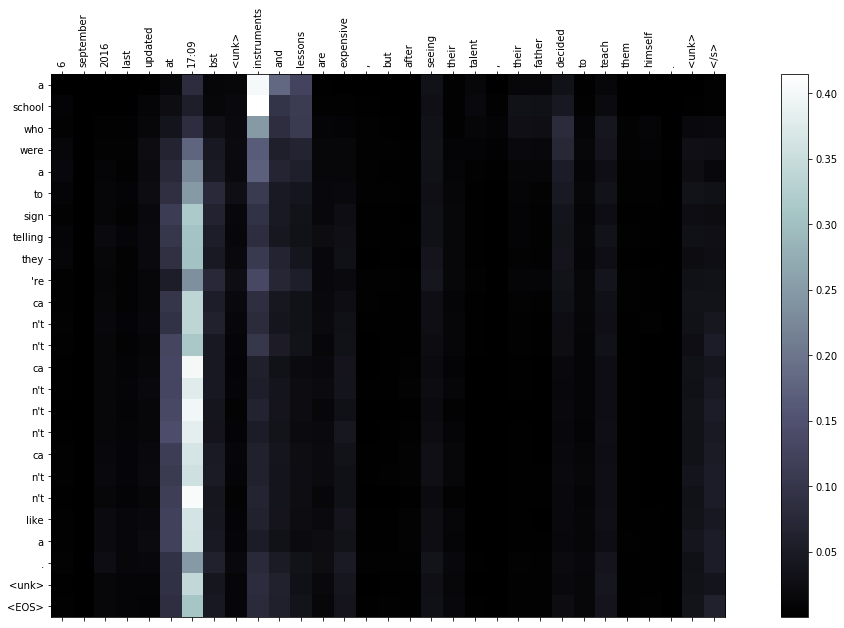

['here', 'is', 'his', 'life', 'in', 'pictures', ':', '<unk>', 'minder', 'star', 'george', 'cole', 'dies', 'at', '90', '<unk>', 'obituary', ':', 'george', 'cole', '<unk>', '</s>']
['kevin', '<unk>', ',', 'daniel', '<unk>', ',', 'daniel', '<unk>', ',', ',', 'michael', '<unk>', ',', 'who', 'died', 'at', 'the', 'age', 'of', '89', '.', '<unk>', '<EOS>']


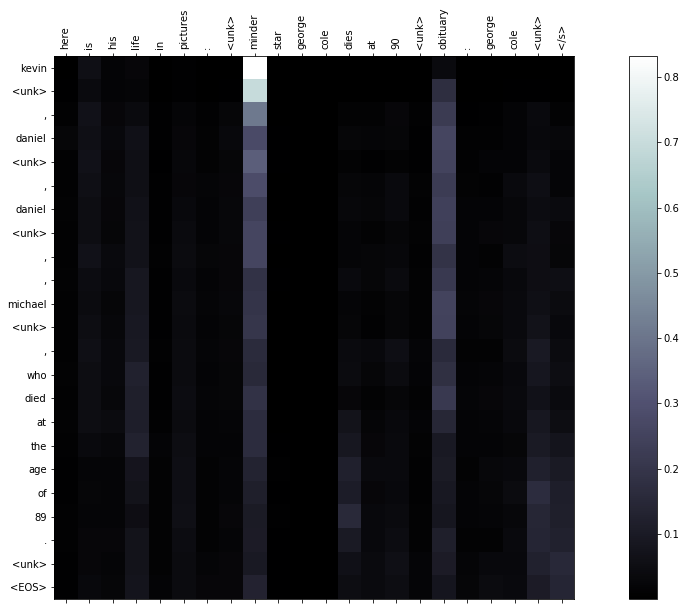

['a', 'selection', 'of', 'photos', 'from', 'africa', 'and', 'of', 'africans', 'elsewhere', 'in', 'the', 'world', 'this', 'week', ':', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'epa', ',', 'getty', 'images', 'and', 'reuters', '<unk>', '<EOS>']


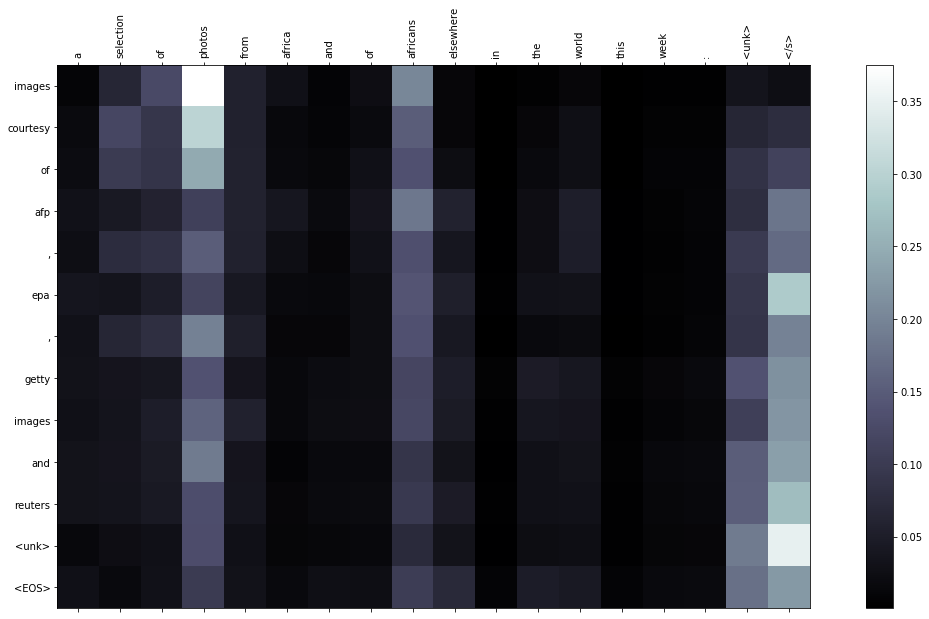

['a', 'selection', 'of', 'the', 'best', 'photos', 'from', 'across', 'africa', 'and', 'of', 'africans', 'elsewhere', 'in', 'the', 'world', 'this', 'week', '.', '<unk>', '</s>']
['images', 'courtesy', 'of', 'afp', ',', 'epa', ',', 'getty', 'images', 'and', 'reuters', '<unk>', '<EOS>']


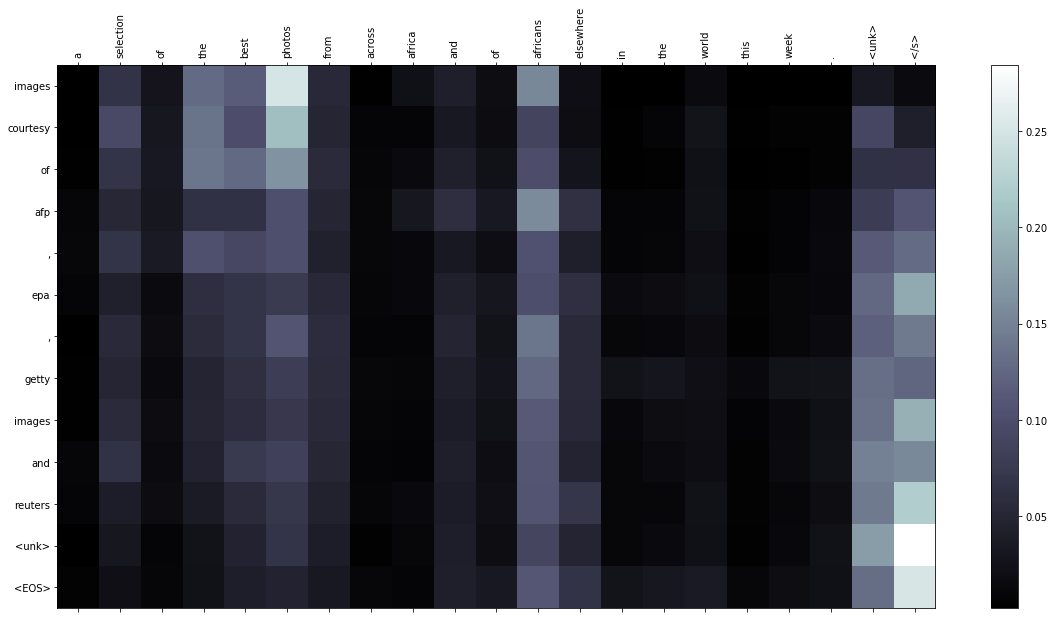

['6', 'september', '2013', 'last', 'updated', 'at', '18:52', 'bst', '<unk>', 'in', 'an', 'interview', 'with', 'the', 'bbc', ',', 'nolan', 'bushnell', 'said', 'the', 'japanese', 'firm', 'was', 'left', 'in', 'a', '"', 'very', 'difficult', 'position', '"', '.', '<unk>', '</s>']
['japan', "'s", 'chief', 'executive', 'of', 'the', 'international', 'has', 'has', 'has', 'a', 'key', 'of', 'the', 'development', 'of', 'the', 'development', 'of', 'the', 'development', 'in', 'the', 'york', '’s', '.', '<unk>', '<EOS>']


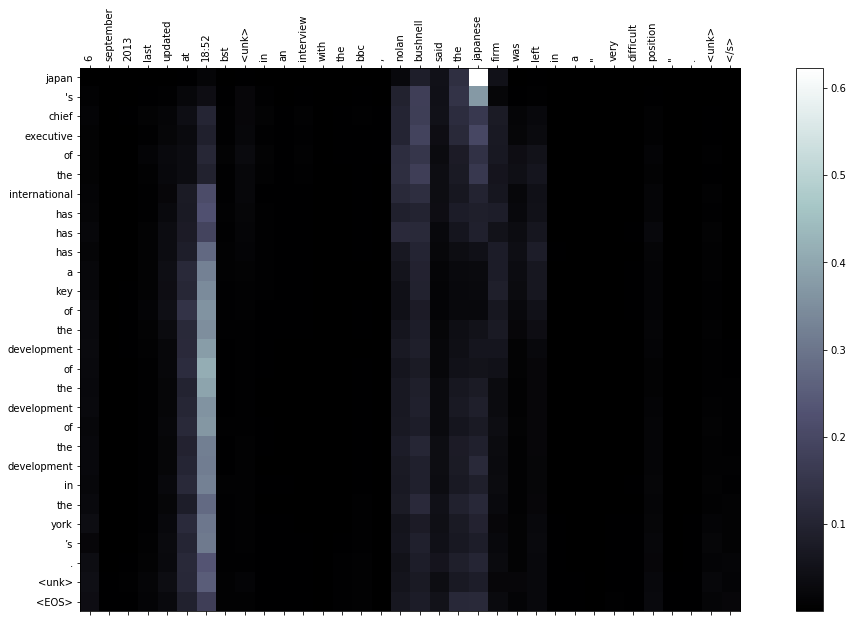

In [119]:
tokenizer = Tokenizer(embedding.vocab, lower=False)
pairs = generate_pair(test)
out = predict(seq2seq.encoder, seq2seq.decoder, embedding.vocab, pairs)
# predict_out(out, OUT_DATA_PATH)

In [ ]:
decoder_attentions = torch.zeros(10, 10, 10)
decoder_attentions[:8]